<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AALU_Coding/blob/main/k_means_clustering_on_image_data_v2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.feature import hog
from collections import Counter
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Load VGG19 model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Pre-trained VGG19 model for feature extraction
vgg_model = VGG19(weights="imagenet", include_top=False)

# Select intermediate layers for feature maps
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Choose desired layers
outputs = [vgg_model.get_layer(name).output for name in layer_names]

# Feature extractor model
vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=outputs)

# Feature extraction function
def extract_features(image_path, feature_type):
    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}")
    image = cv2.resize(image, (512, 512))  # Normalize image size to 512x512

    if feature_type == 'hu':
        # Hu Moments
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        moments = cv2.moments(gray)
        features = cv2.HuMoments(moments).flatten()
        return features, None
    elif feature_type == 'hog':
        # HOG features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features, hog_image = hog(
            gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True
        )
        return features, hog_image
    elif feature_type == 'vgg19':
        # VGG19 feature maps
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array = preprocess_input(image_array)  # Preprocess for VGG19
        feature_maps = vgg_feature_extractor.predict(image_array)  # Extract features from selected layers
        return feature_maps, None
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
"""
# Select feature type: 'hu', 'hog', or 'vgg19'
feature_type = 'vgg19'  #@param{type:'string'} ['hu', 'hog', 'vgg19']

# Pre-trained VGG19 model for feature extraction (if using vgg19)
if feature_type == 'vgg19':
    vgg_model = VGG19(weights="imagenet", include_top=False)
    layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=outputs)


# Feature extraction function
def extract_features(image_path, feature_type):
    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}")
    new_size = 32  #@param{type:'integer'}
    image = cv2.resize(image, (new_size, new_size))  # Normalize image size to new_size x new_size

    if feature_type == 'hu':
        # Hu Moments
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        moments = cv2.moments(gray)
        features = cv2.HuMoments(moments).flatten()
        return features, None
    elif feature_type == 'hog':
        # HOG features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features, hog_image = hog(
            gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True
        )
        return features, hog_image
    elif feature_type == 'vgg19':
        # VGG19 feature maps
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array = preprocess_input(image_array)  # Preprocess for VGG19
        feature_maps = vgg_feature_extractor.predict(image_array)  # Extract features from selected layers
        return feature_maps, None  # Return unflattened feature maps
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

# Read all images
image_folder = '/content/drive/My Drive/kenetic_facades/image_a'  #@param{type:'string'}
image_paths = [os.path.join(image_folder, image) for image in os.listdir(image_folder) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]

features = []
raw_vgg_features = []

for image_path in image_paths:
    try:
        feature, additional_data = extract_features(image_path, feature_type)
        features.append(feature)
        if feature_type == 'vgg19':
            raw_vgg_features.append(feature)  # Keep raw feature maps for visualization
    except ValueError as e:
        print(e)
        continue

# Visualization based on feature type
if feature_type == 'hu':
    # Print Hu Moments
    print("Hu Moments for all images:")
    for i, feature in enumerate(features):
        print(f"Image {i+1}: {feature}")
elif feature_type == 'hog':
    # Visualize HOG Images
    print("Visualizing HOG Images...")
    n = len(features)
    cols = 5
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(20, 4 * rows))
    for i, feature in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature, cmap='gray')
        plt.axis('off')
    plt.show()
elif feature_type == 'vgg19':
    # Visualize VGG19 Feature Maps
    print("Visualizing VGG19 Feature Maps...")
    for i, feature_maps in enumerate(raw_vgg_features):
        try:
            n_layers = len(feature_maps)  # Number of selected layers
            plt.figure(figsize=(20, 4 * n_layers))
            for j, feature_map in enumerate(feature_maps):
                if feature_map.ndim == 4:  # Ensure batch dimension exists
                    feature_map = feature_map[0]  # Remove batch dimension
                # Visualize the raw feature map
                plt.subplot(1, n_layers, j + 1)
                plt.imshow(np.mean(feature_map, axis=-1), cmap='viridis')  # Average over channels for visualization
                plt.title(f"Layer: {layer_names[j]}")
                plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing feature maps for image {i+1}: {e}")
            continue

    # Flatten VGG19 features for KMeans
    features = [np.concatenate([np.mean(f[0], axis=(0, 1)) for f in feature_maps]) for feature_maps in raw_vgg_features]
    features = np.array(features)

# KMeans Clustering and SSE
# Use SSE to select k
best_k_values = []  # Store the best k value for each run
SSEs = []  # Store the SSE for each k value

for _ in range(30):  # Run multiple iterations to find stable k
    SSE = []  # Store the sum of squared errors for each result
    for k in range(1, 9):
        estimator = KMeans(n_clusters=k, n_init=10)  # Construct the classifier
        estimator.fit(features)  # Fit the features
        SSE.append(estimator.inertia_)
    # Use second derivative to find the elbow point
    best_k = np.argmin(np.diff(SSE, 2)) + 2
    best_k_values.append(best_k)
    SSEs.append(SSE)

# Print all k values
print(f"All k values are: {best_k_values}")

# Find the most common k value
counter = Counter(best_k_values)
best_k = counter.most_common(1)[0][0]

print(f"The best k value is: {best_k}")

# Create a colour map
cmap = plt.cm.get_cmap('inferno', 30)

# Plot the line graph
fig, ax = plt.subplots(figsize=(10, 6))

# Draw a light grey vertical dashed line at the best k value
ax.axvline(x=best_k, linestyle='--', color='lightgray')

for i, SSE in enumerate(SSEs):
    color = cmap(i)
    ax.plot(range(1, 9), SSE, '-o', marker='x', color=color, label=f'Run {i+1}', linewidth=0.5)

ax.set_xlabel('k')
ax.set_ylabel('SSE')

# Draw a red marker at the best k value in the line graph
for i, best_k_value in enumerate(best_k_values):
    if best_k_value == best_k:
        ax.plot(best_k_value, SSEs[i][best_k_value-1], 'green', marker='o', markersize=5)

# Move the legend to the right and make it the same height as the chart
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
"""

'\n# Select feature type: \'hu\', \'hog\', or \'vgg19\'\nfeature_type = \'vgg19\'  #@param{type:\'string\'} [\'hu\', \'hog\', \'vgg19\']\n\n# Pre-trained VGG19 model for feature extraction (if using vgg19)\nif feature_type == \'vgg19\':\n    vgg_model = VGG19(weights="imagenet", include_top=False)\n    layer_names = [\'block1_conv1\', \'block2_conv1\', \'block3_conv1\', \'block4_conv1\', \'block5_conv1\']\n    outputs = [vgg_model.get_layer(name).output for name in layer_names]\n    vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=outputs)\n\n\n# Feature extraction function\ndef extract_features(image_path, feature_type):\n    # Read and preprocess image\n    image = cv2.imread(image_path)\n    if image is None:\n        raise ValueError(f"Error: Unable to read image at {image_path}")\n    new_size = 32  #@param{type:\'integer\'}\n    image = cv2.resize(image, (new_size, new_size))  # Normalize image size to new_size x new_size\n\n    if feature_type == \'hu\':\n        # 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

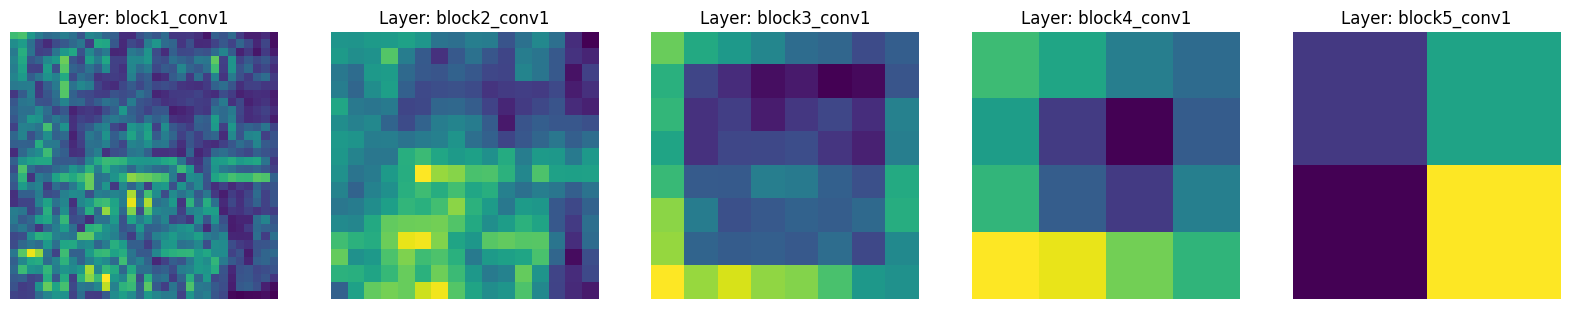

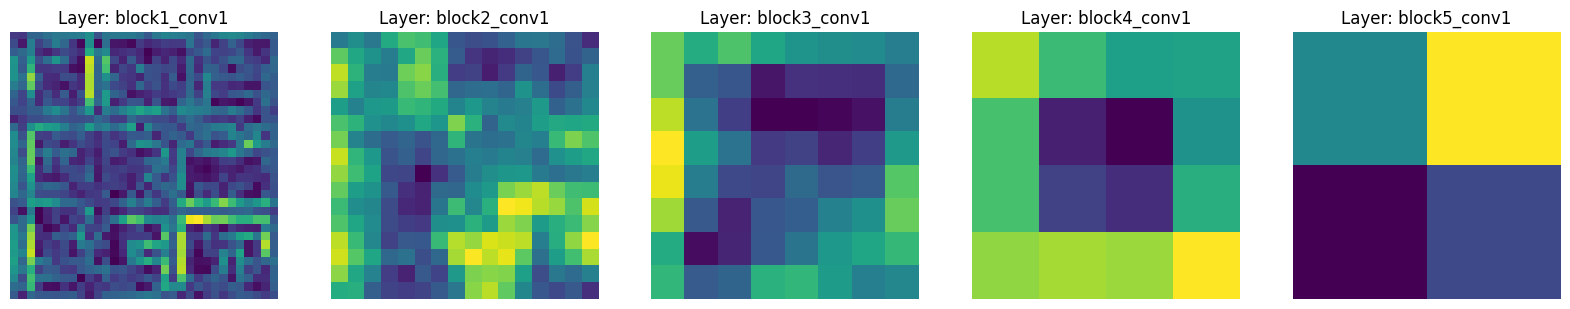

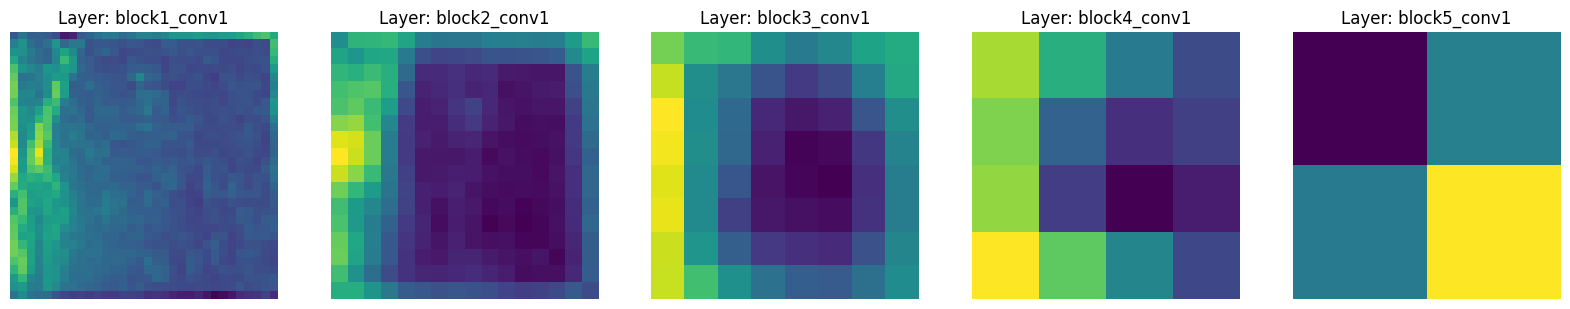

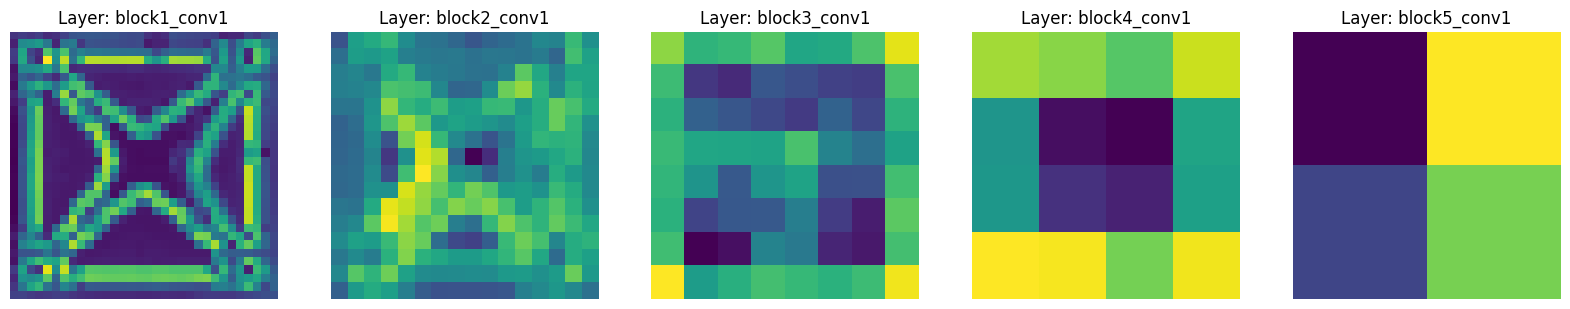

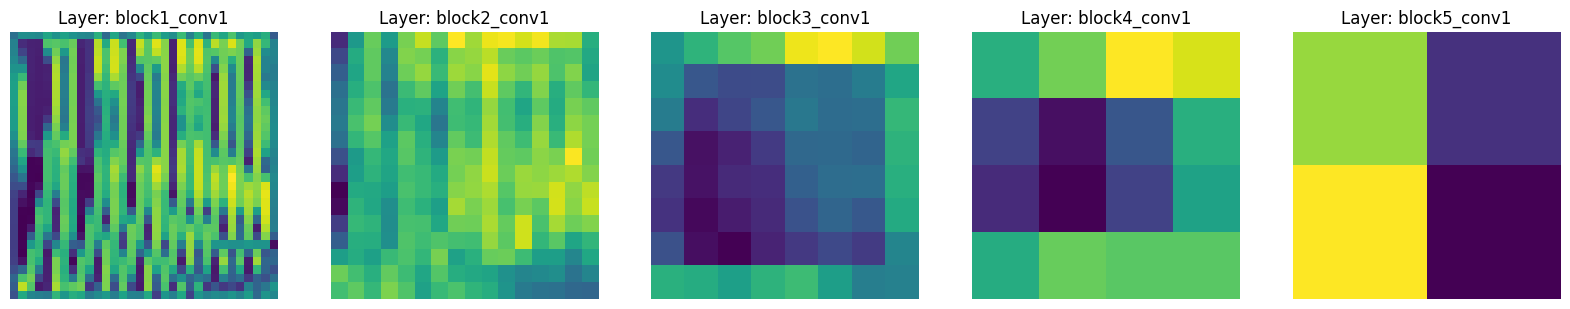

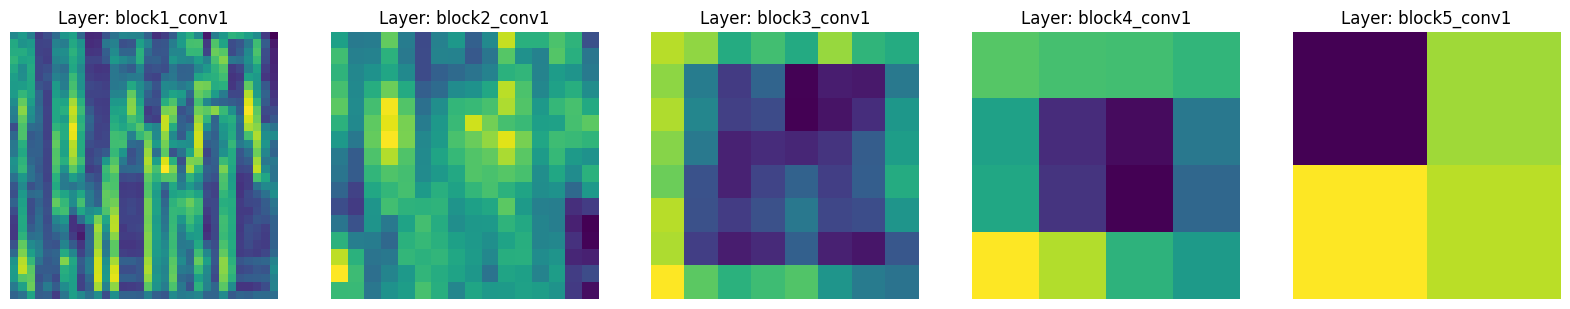

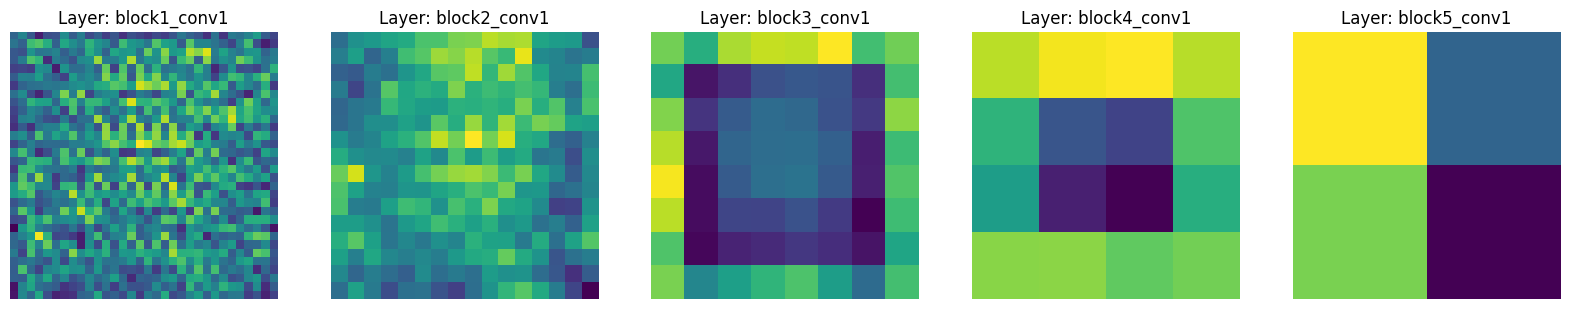

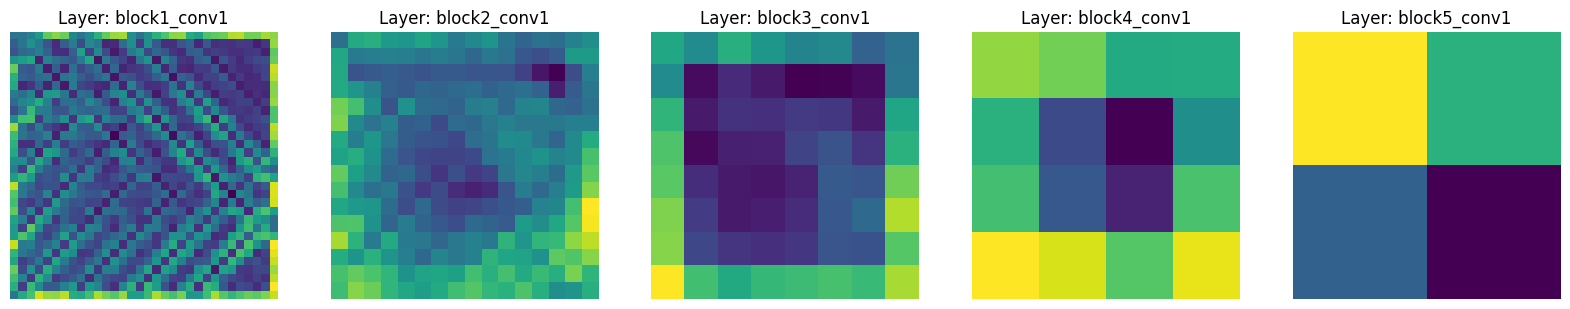

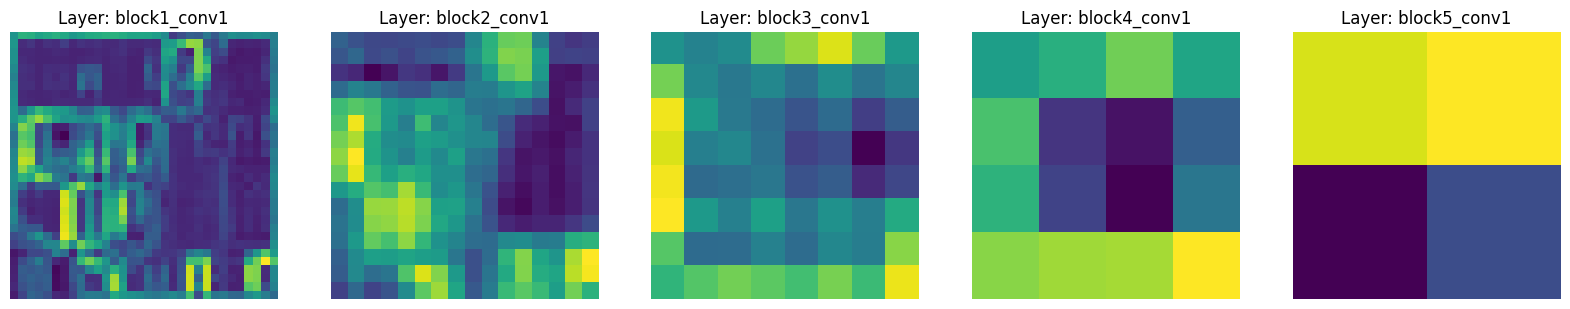

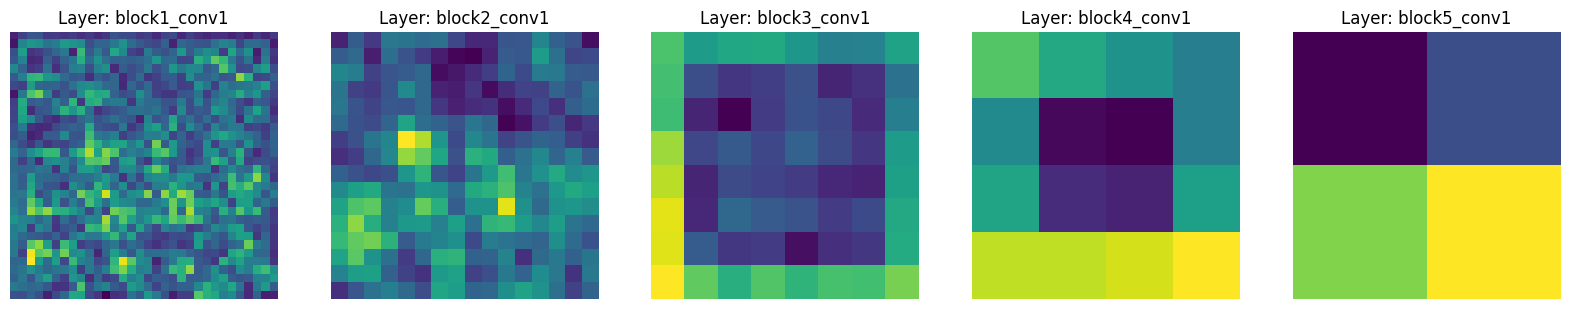

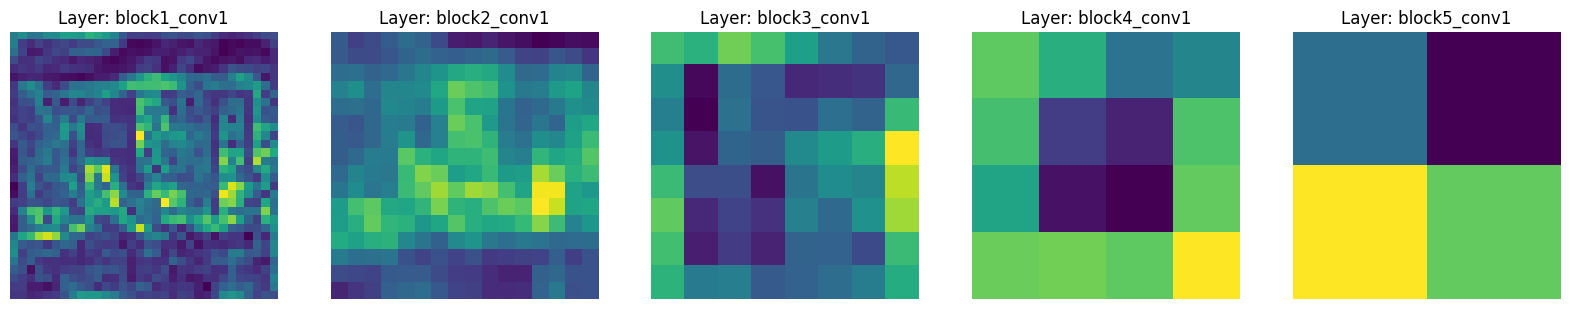

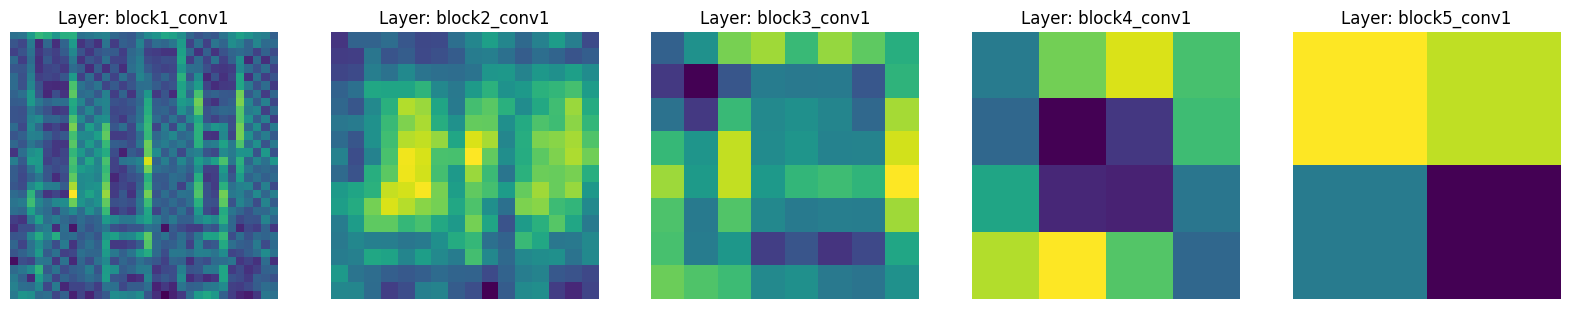

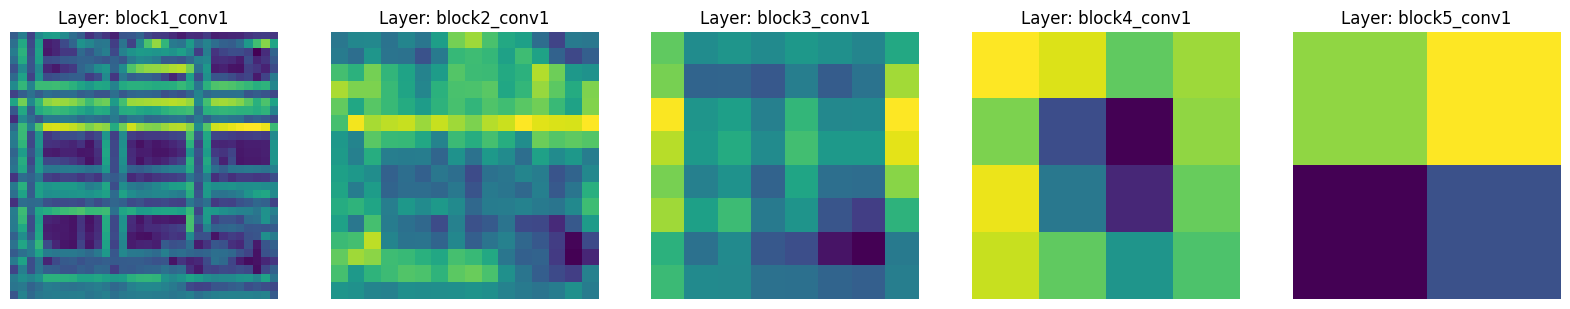

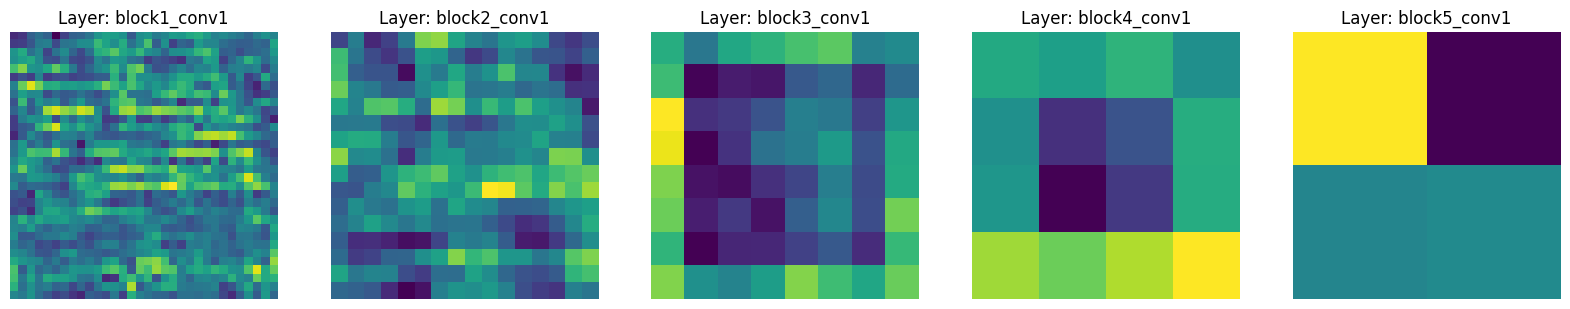

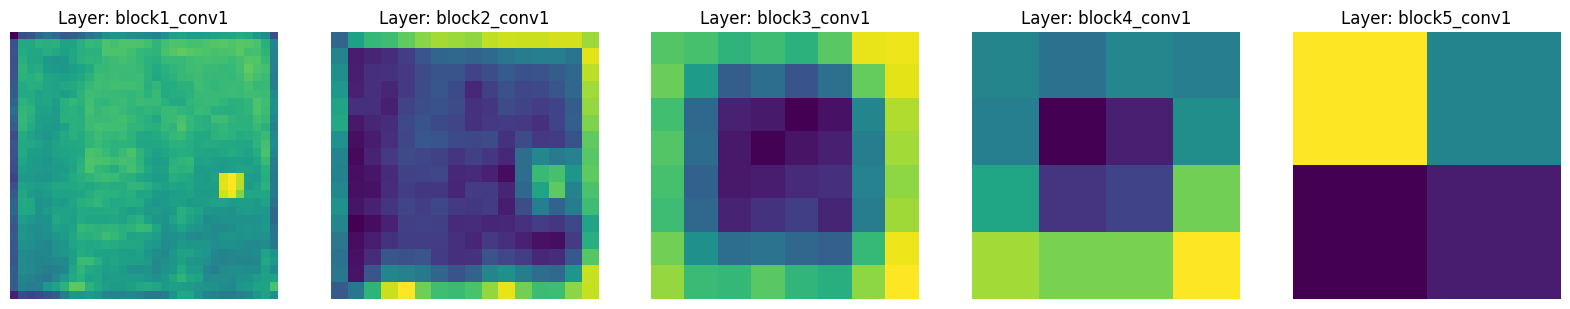

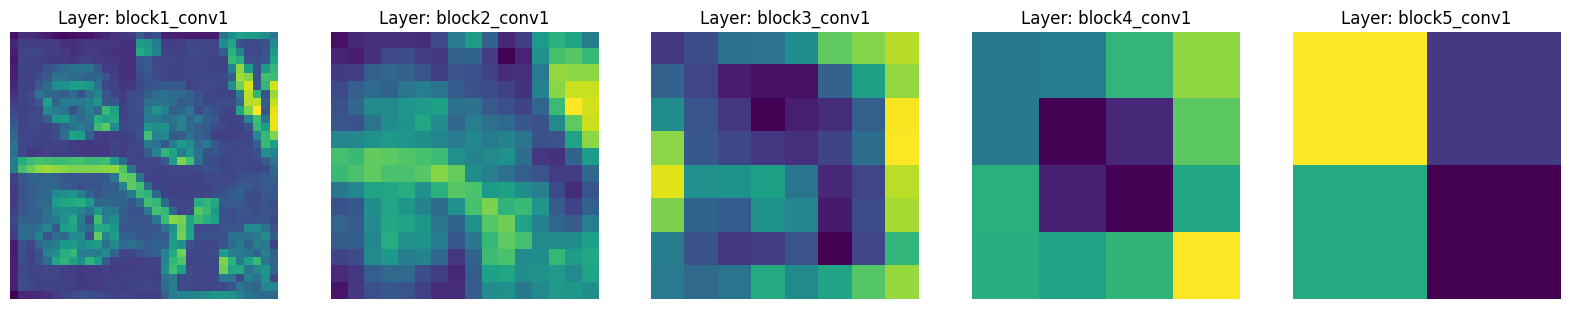

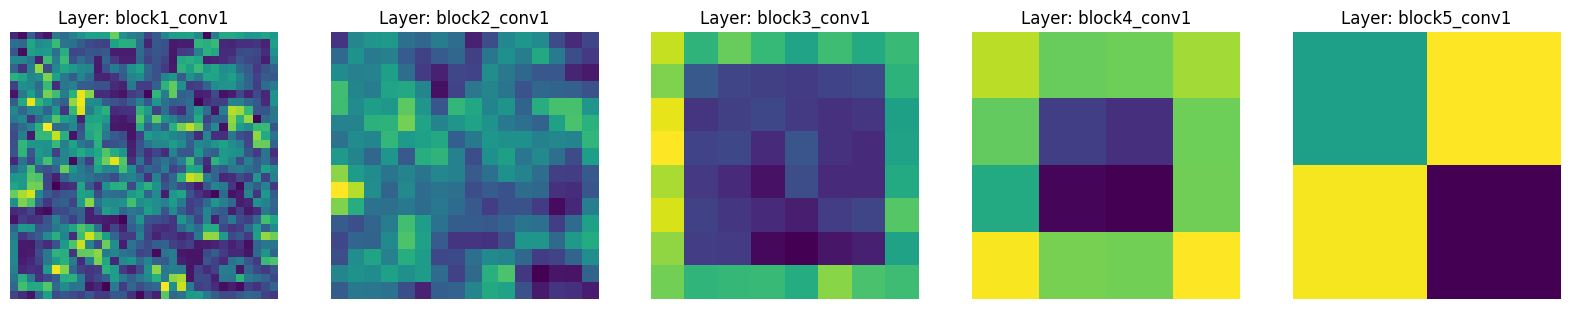

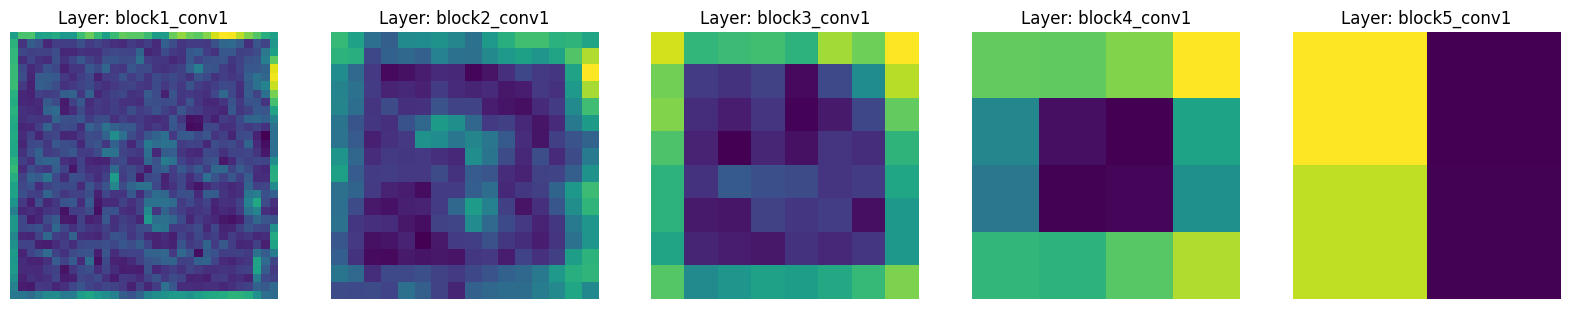

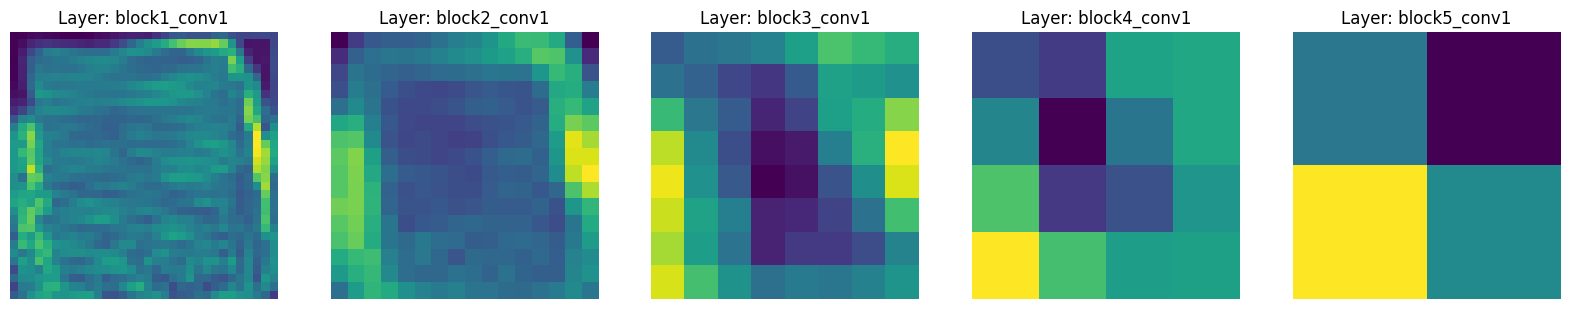

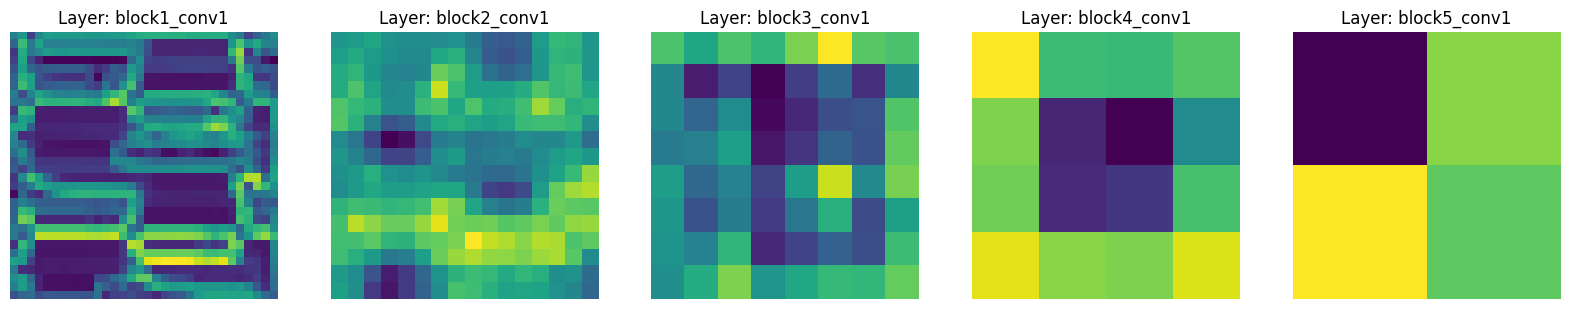

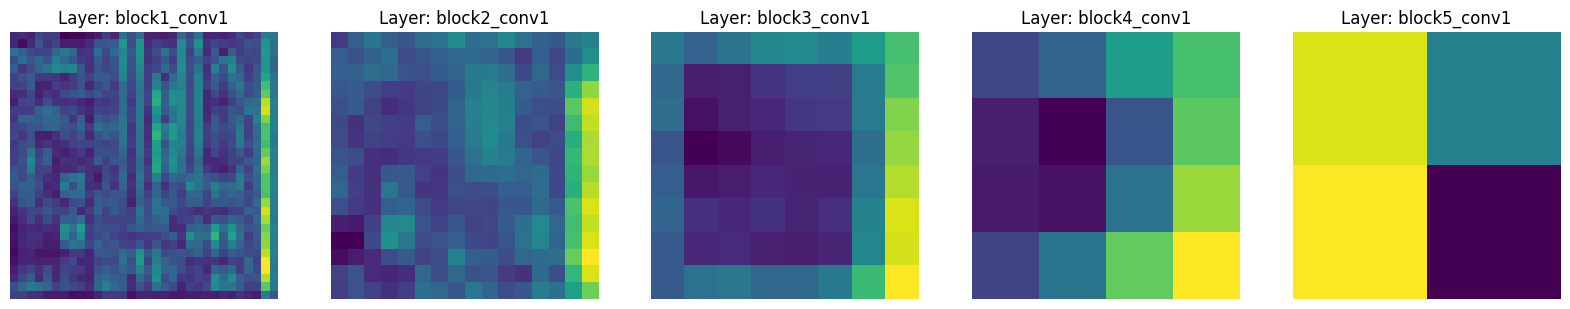

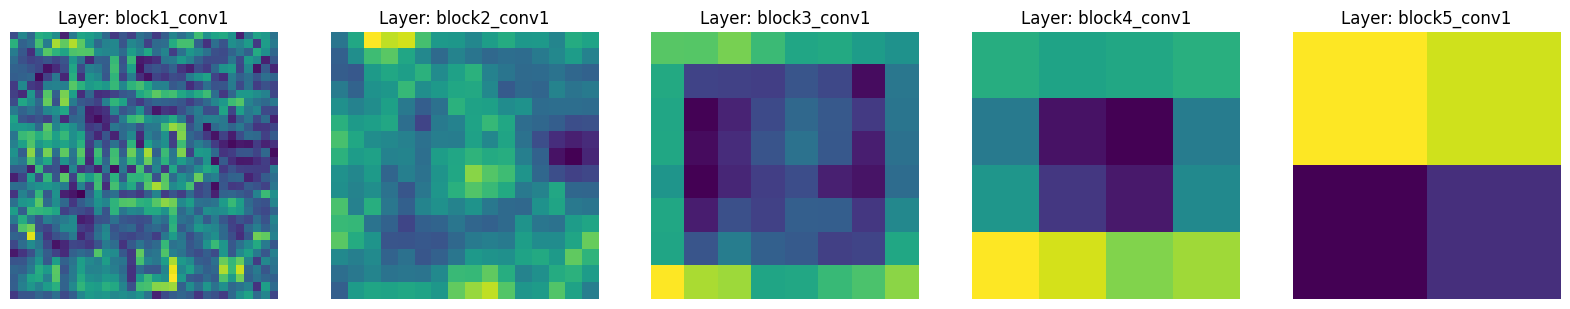

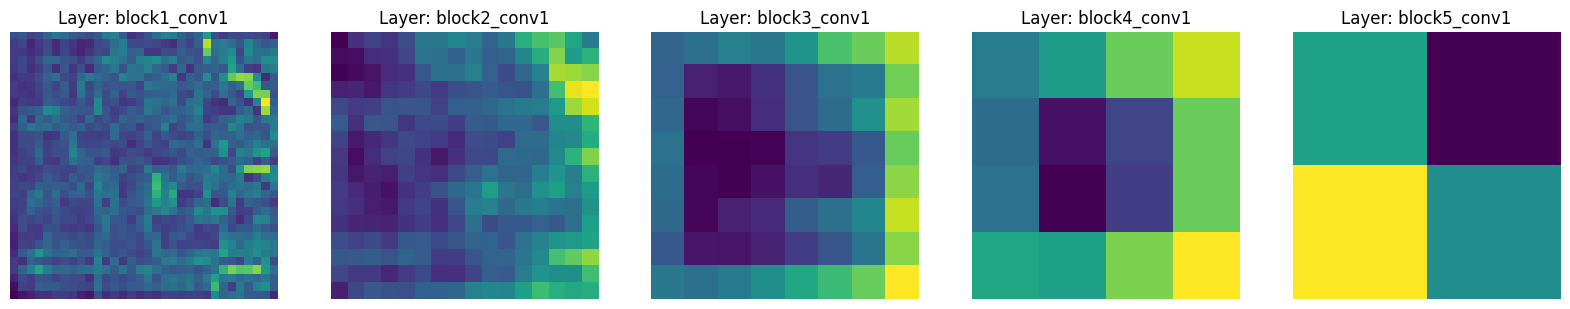

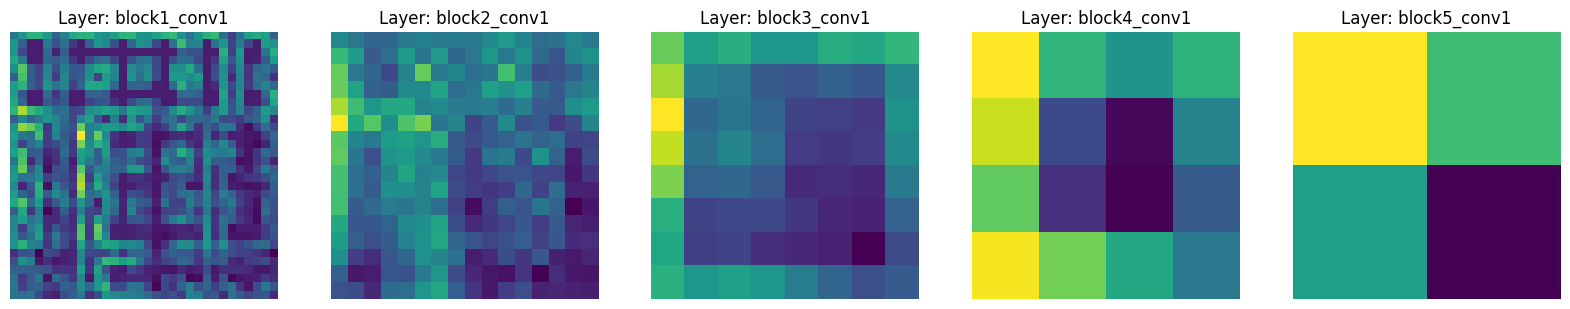

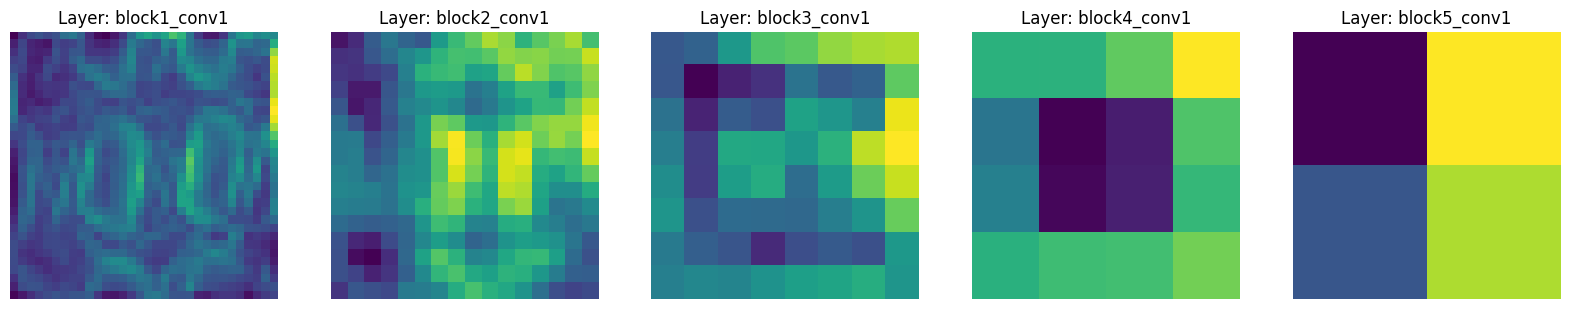

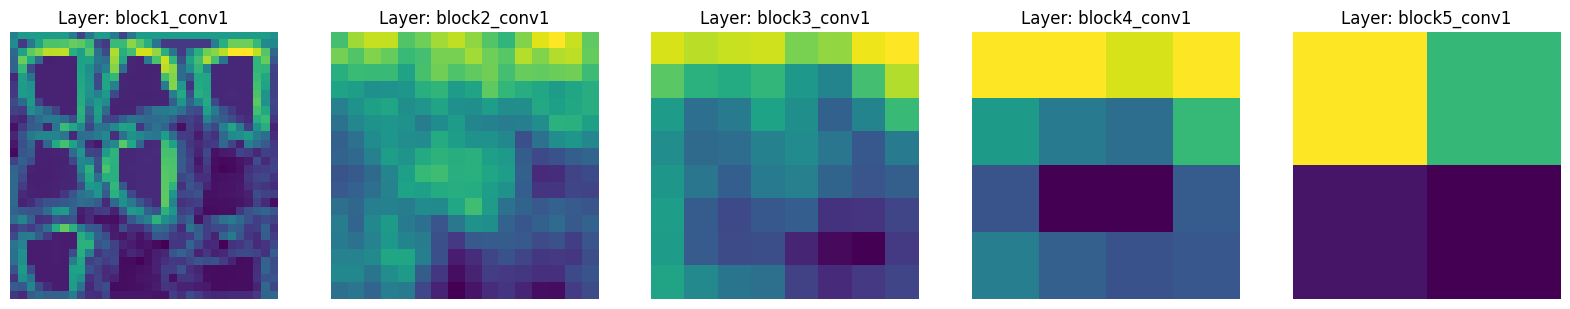

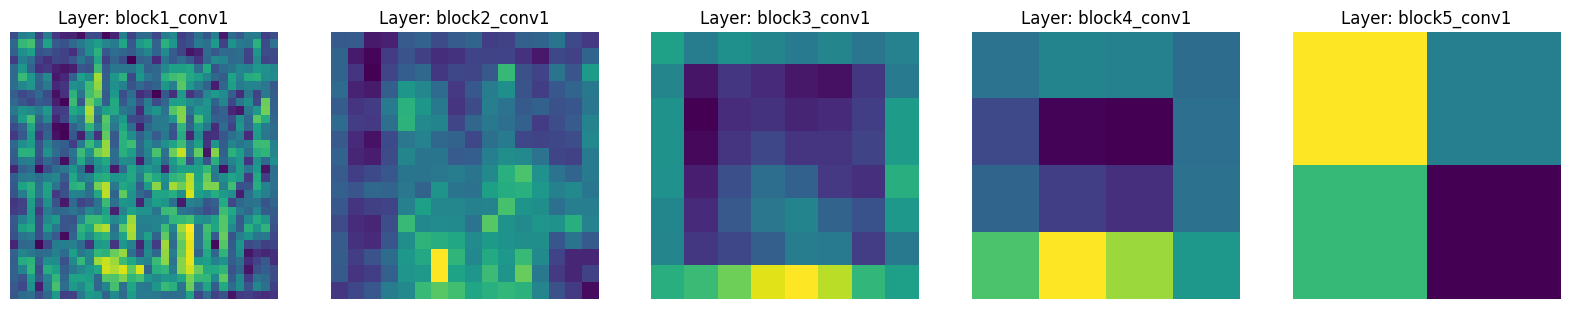

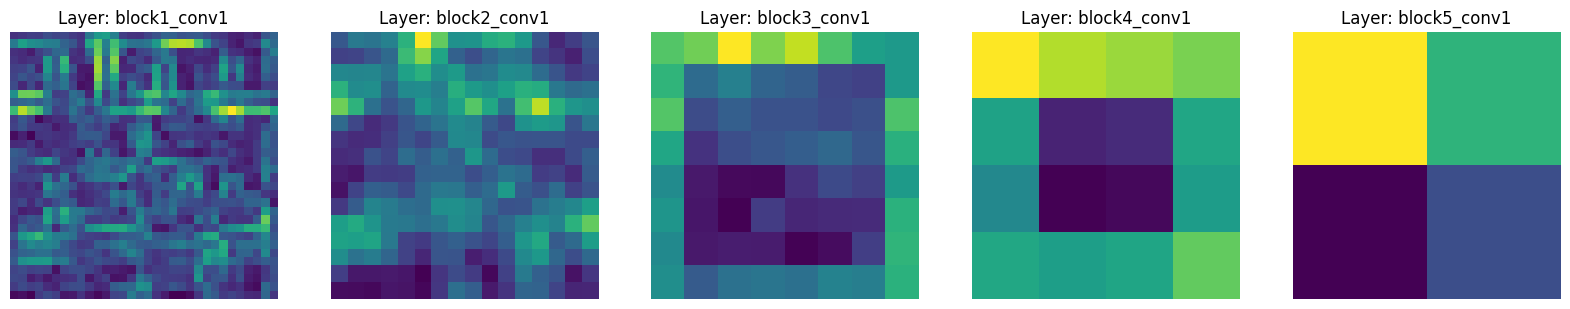

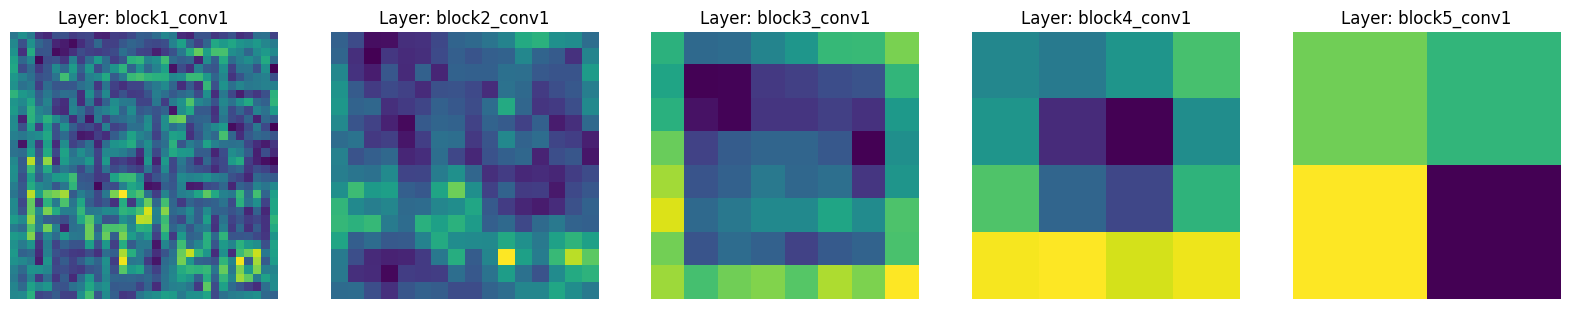

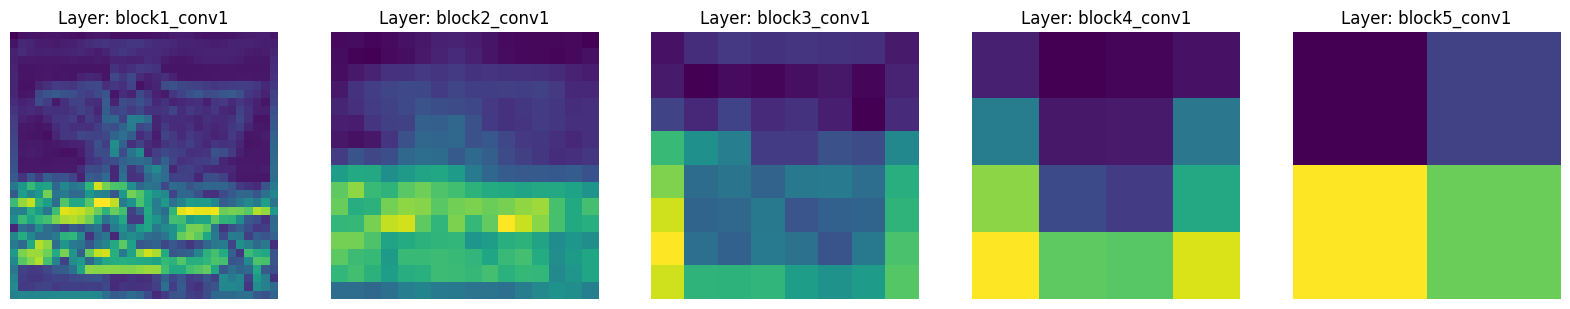

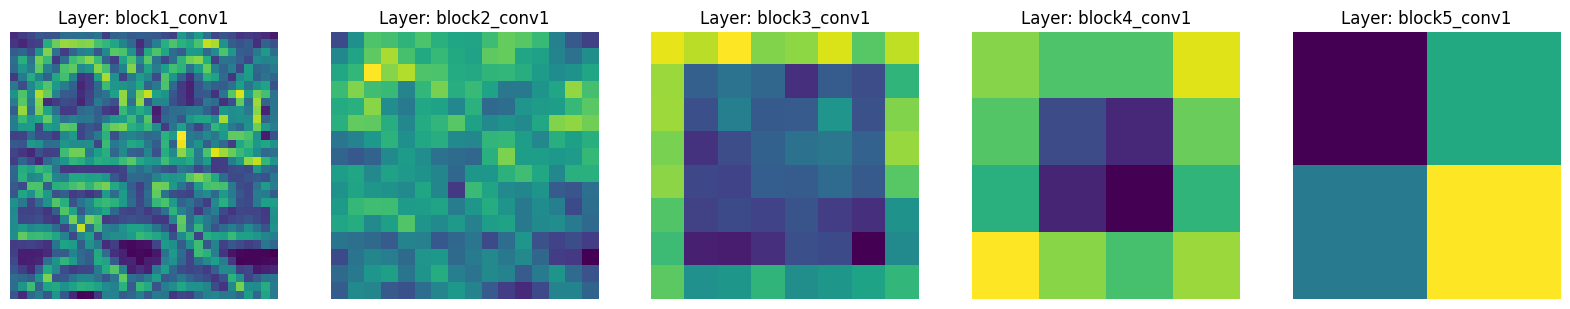

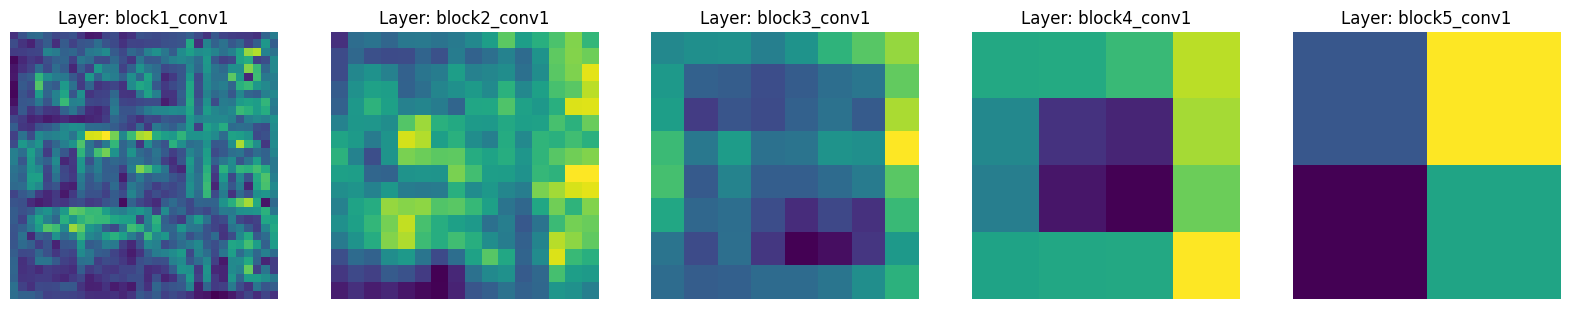

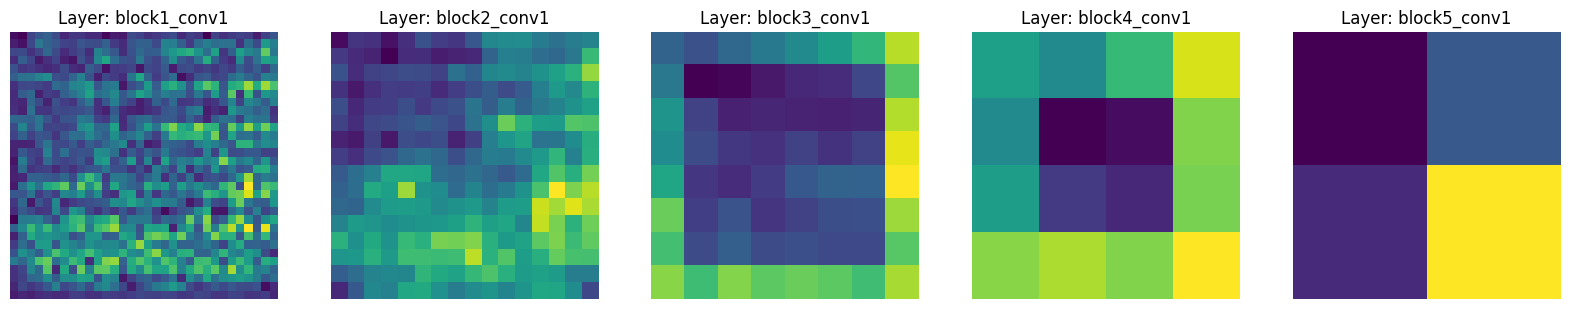

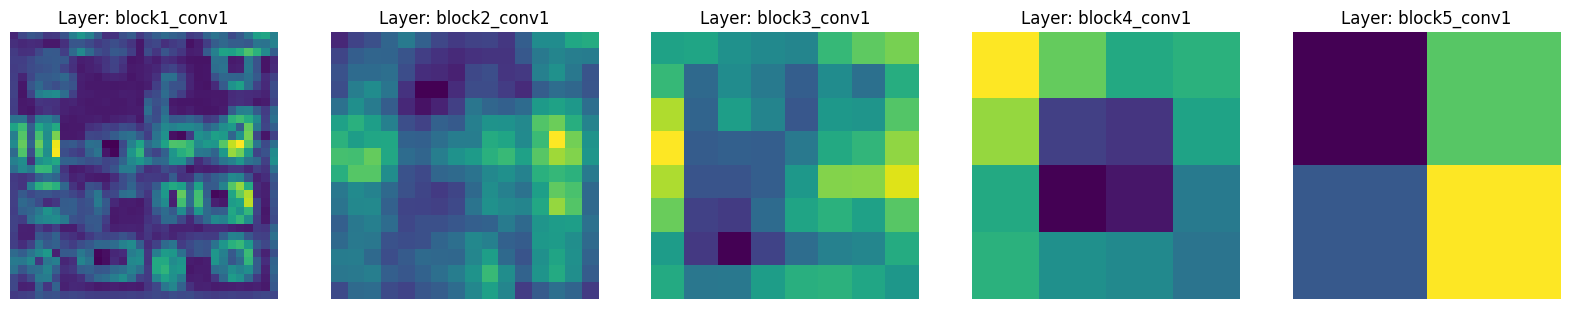

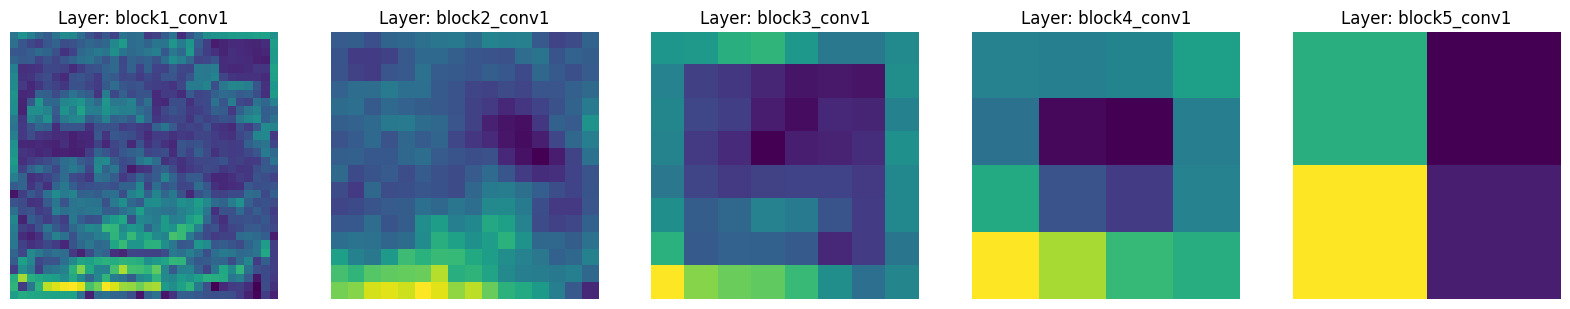

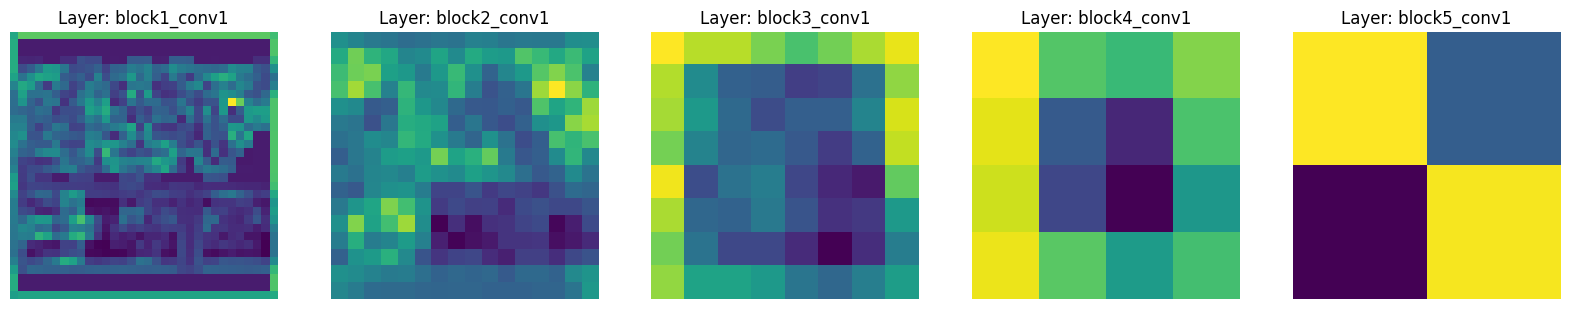

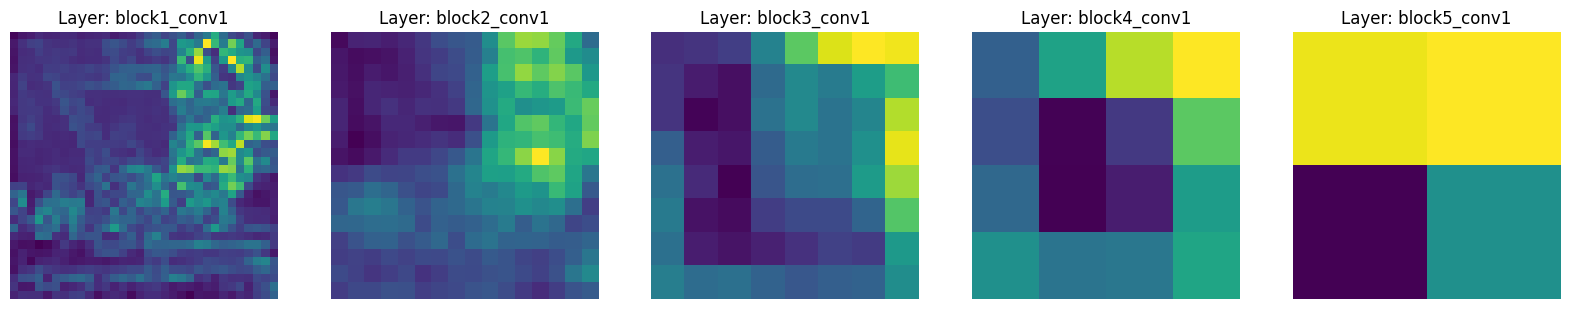

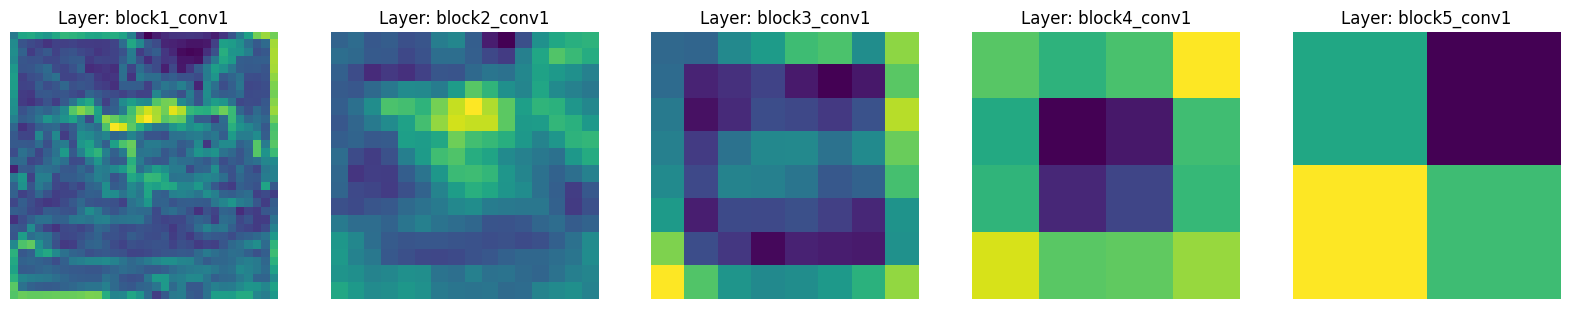

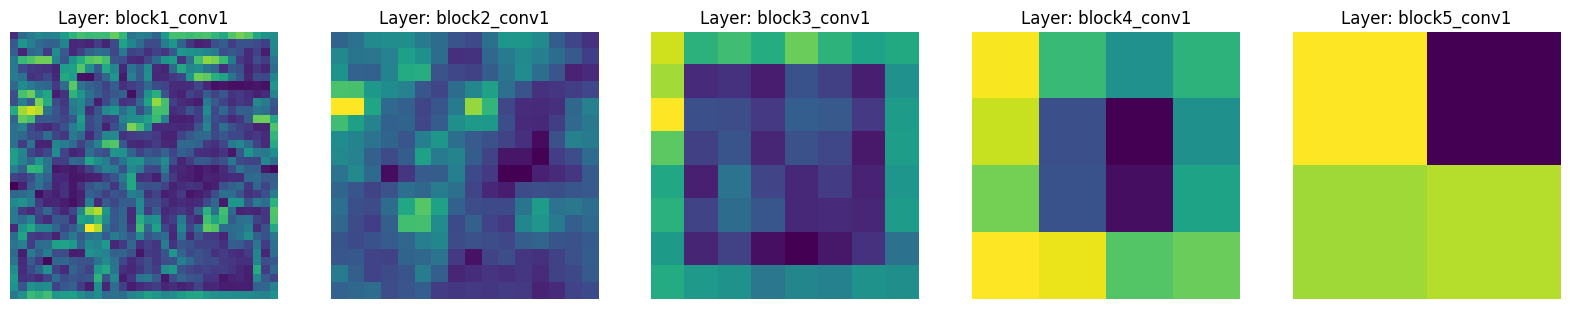

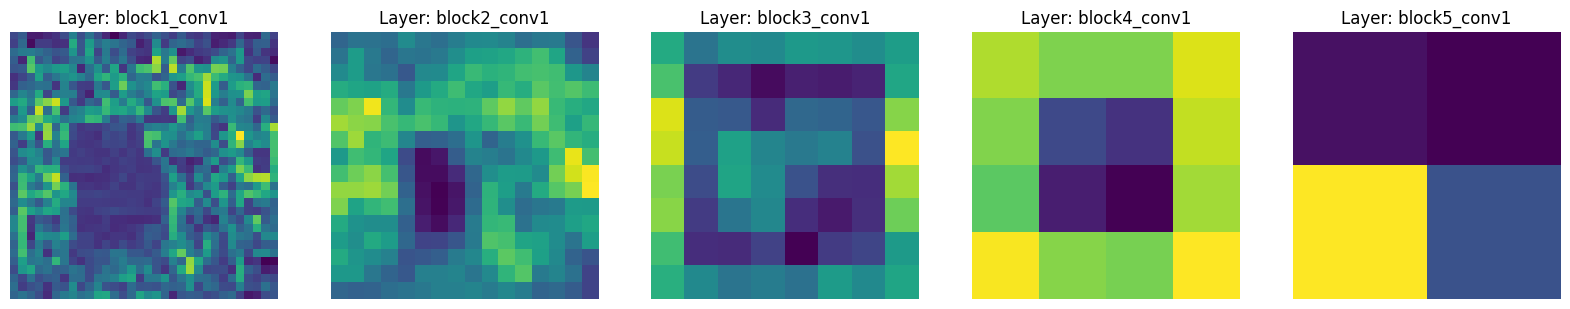

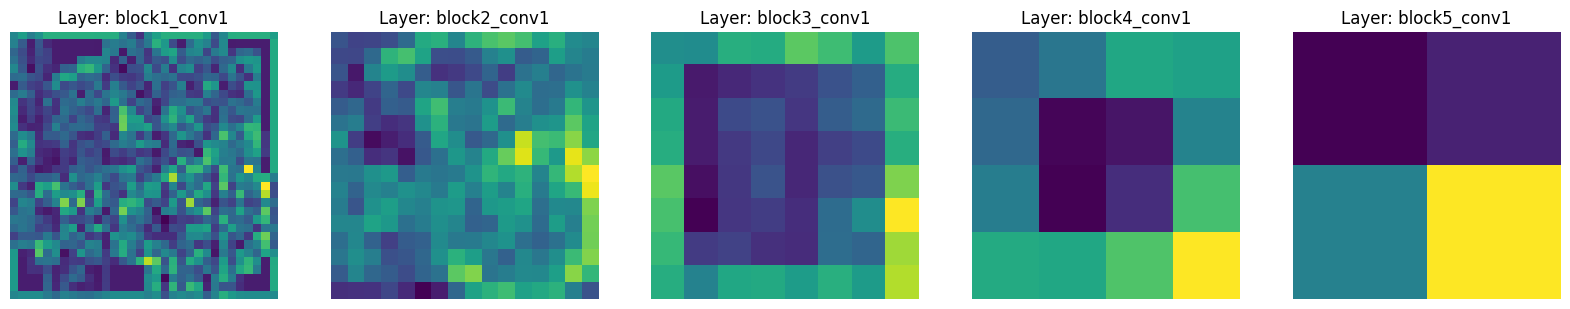

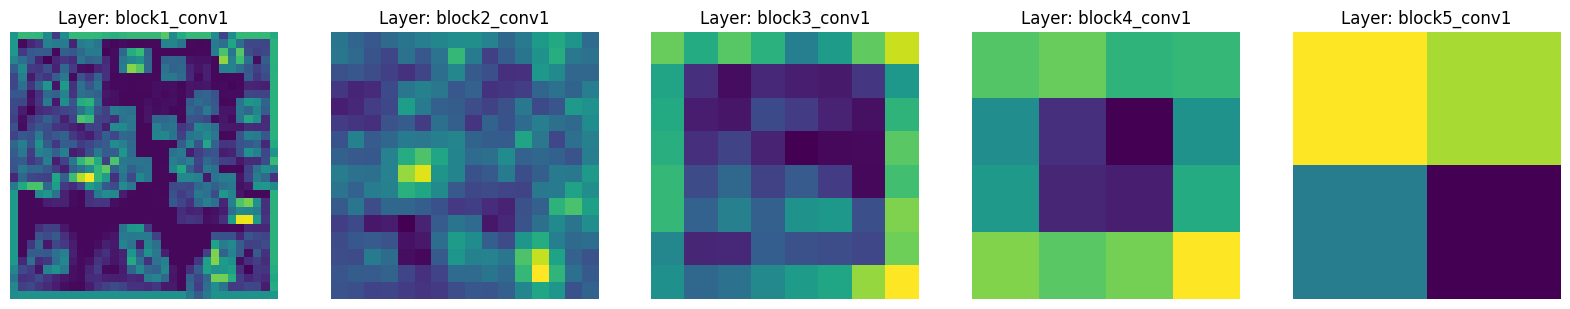

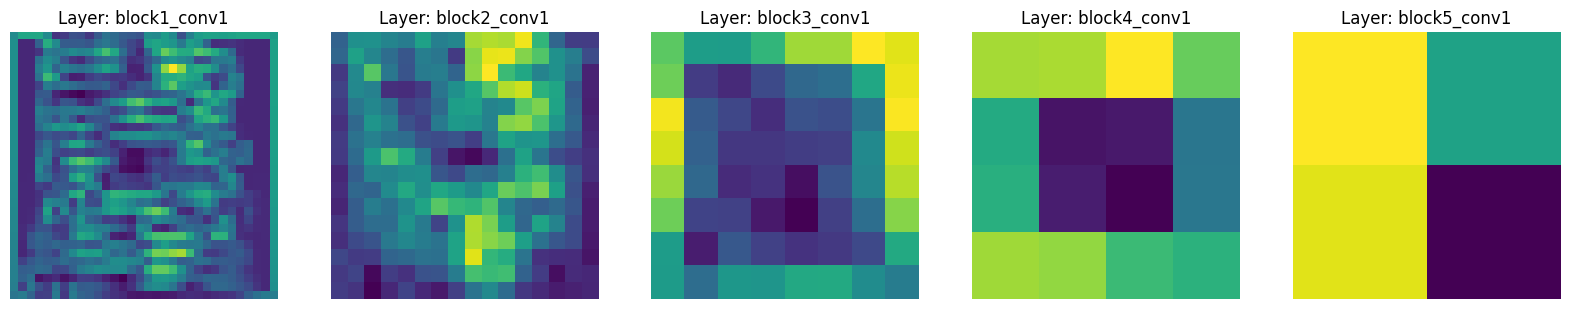

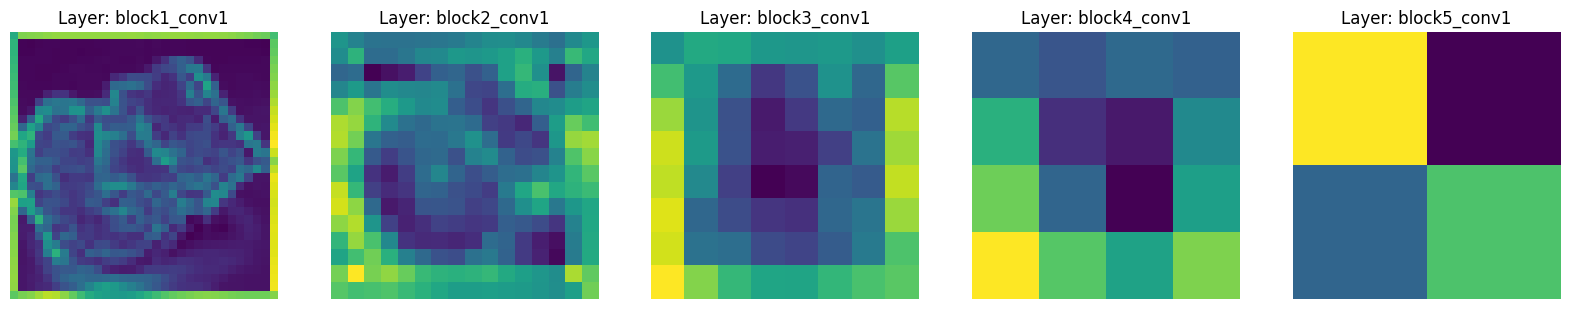

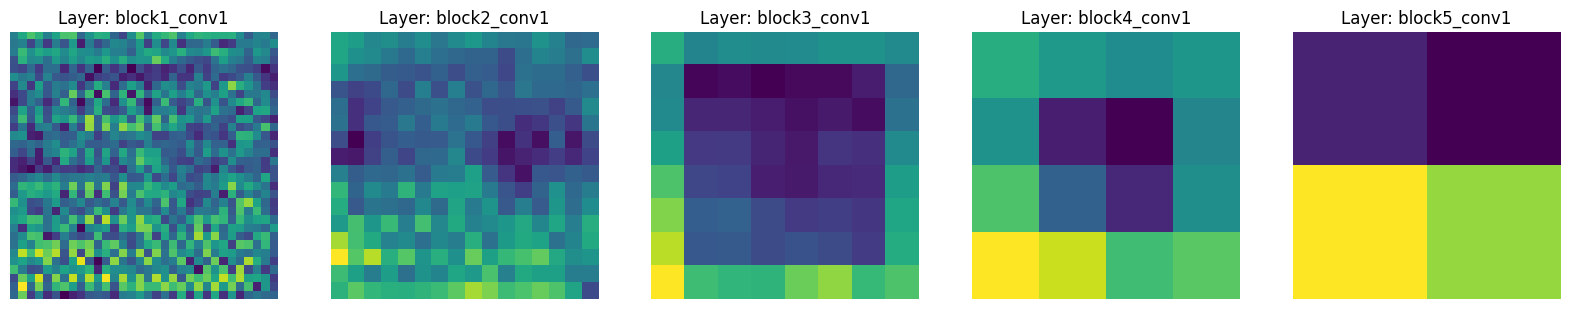

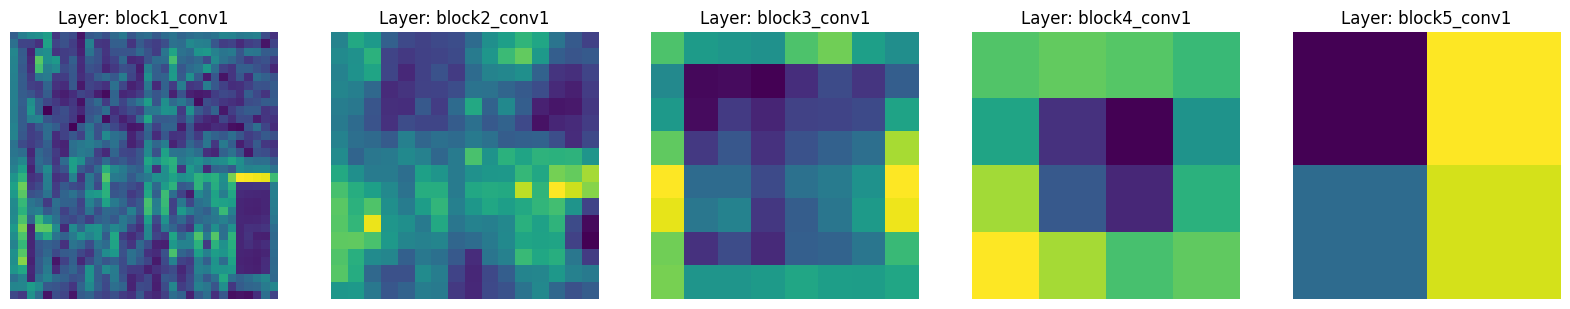

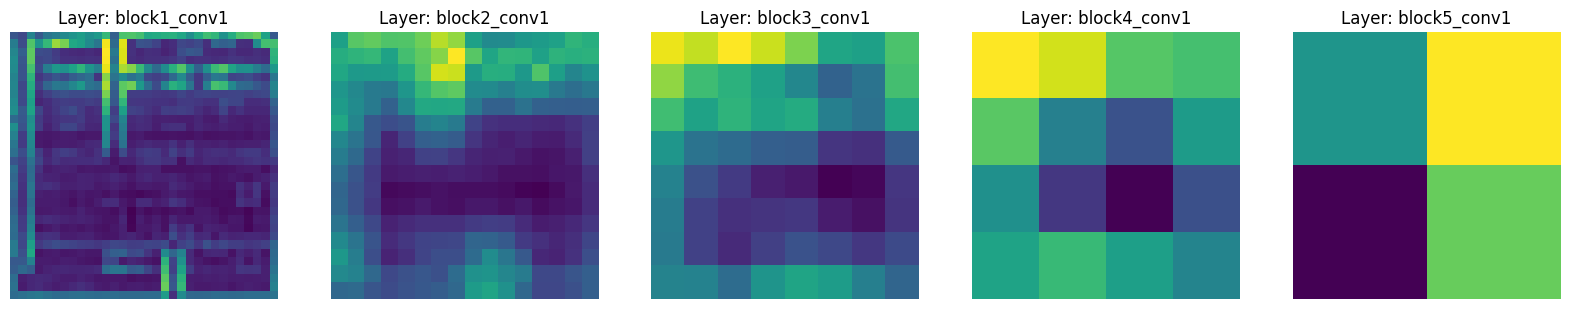

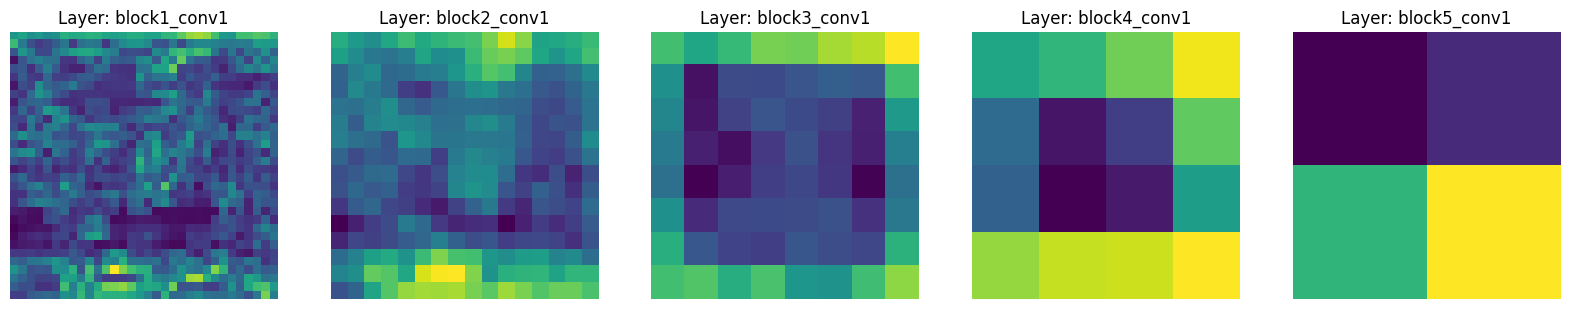

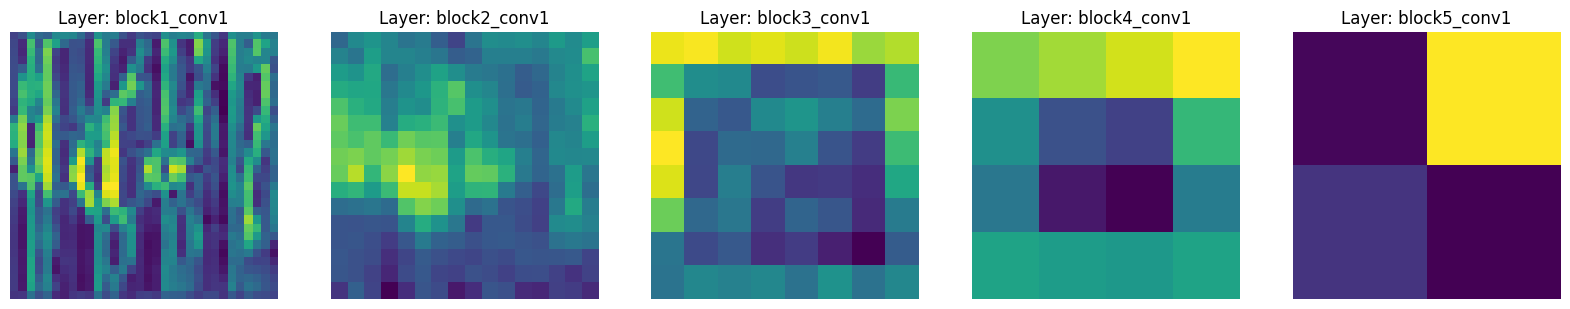

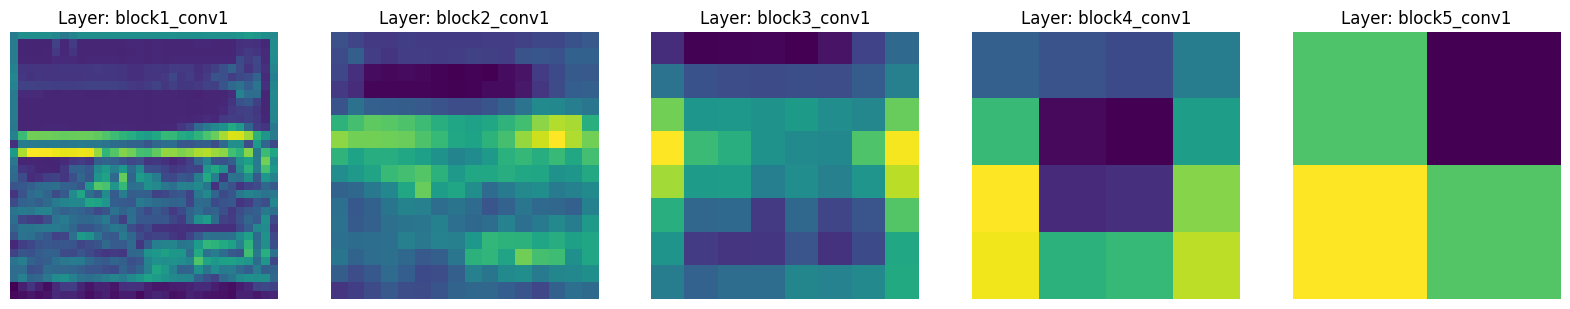

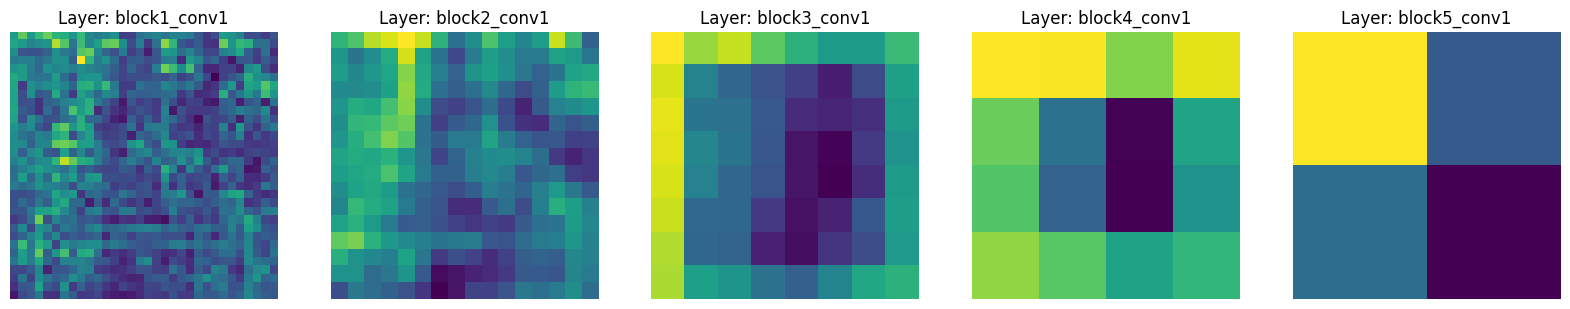

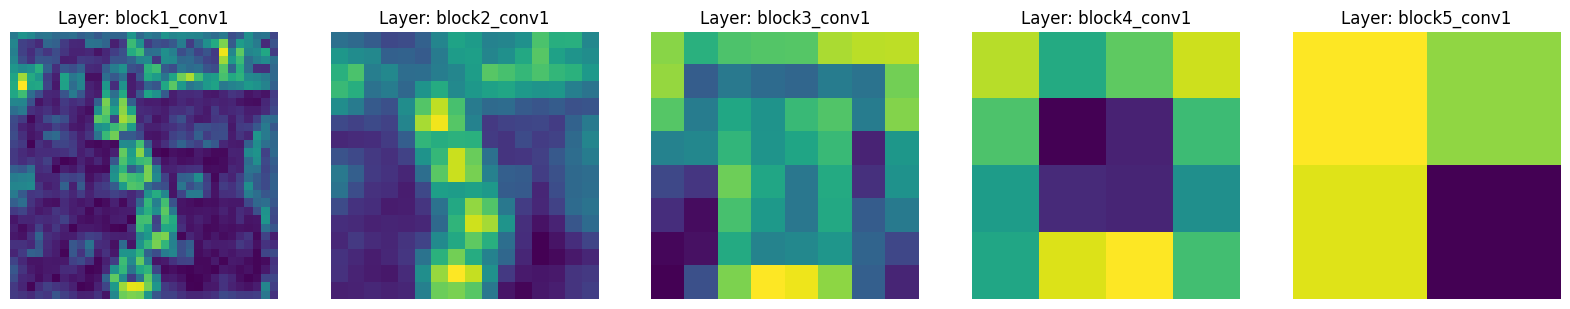

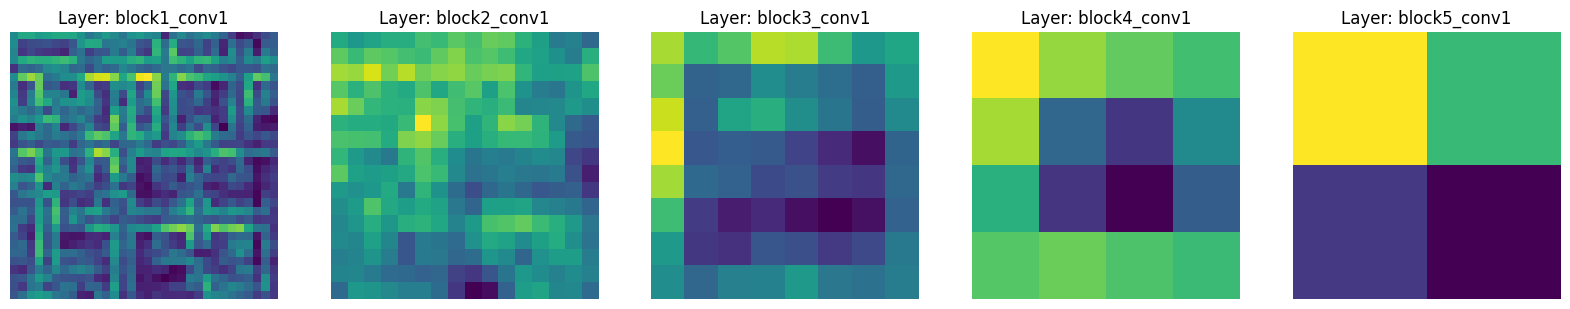

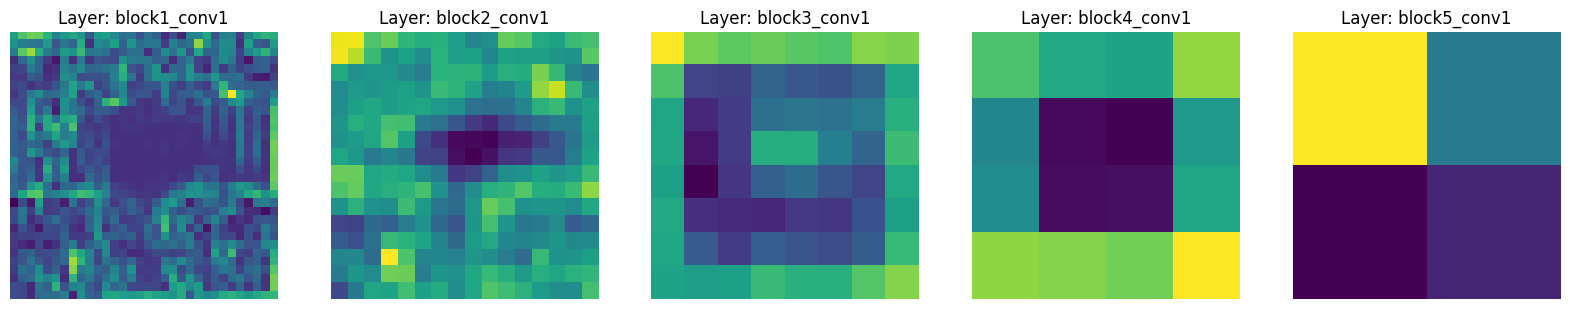

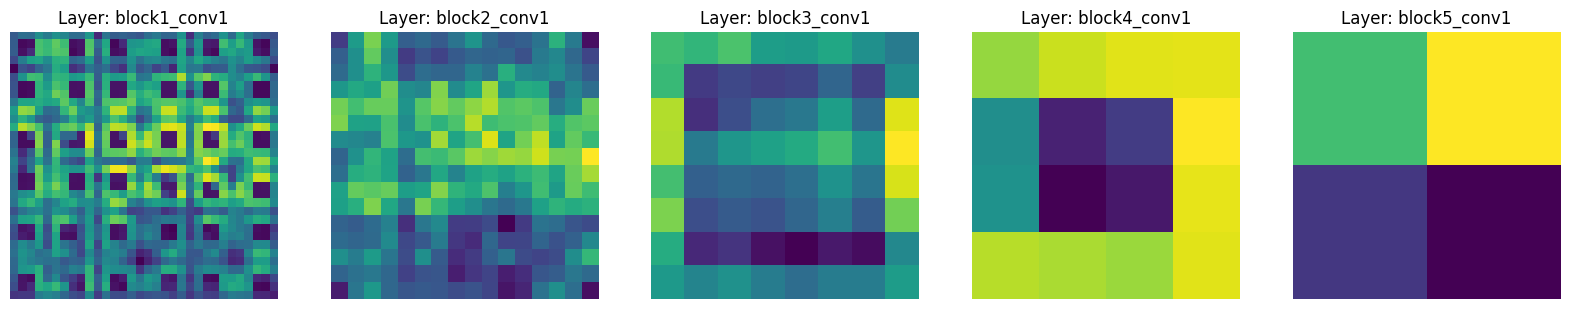

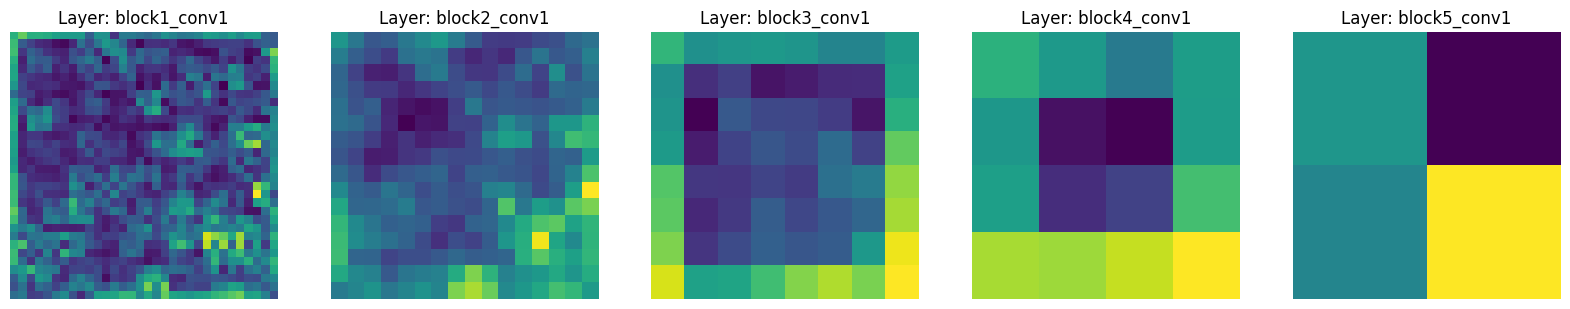

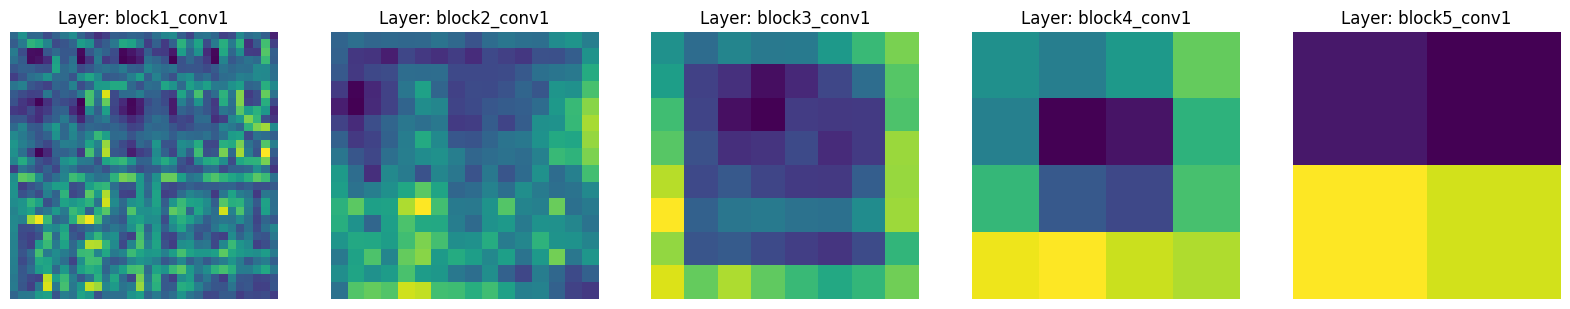

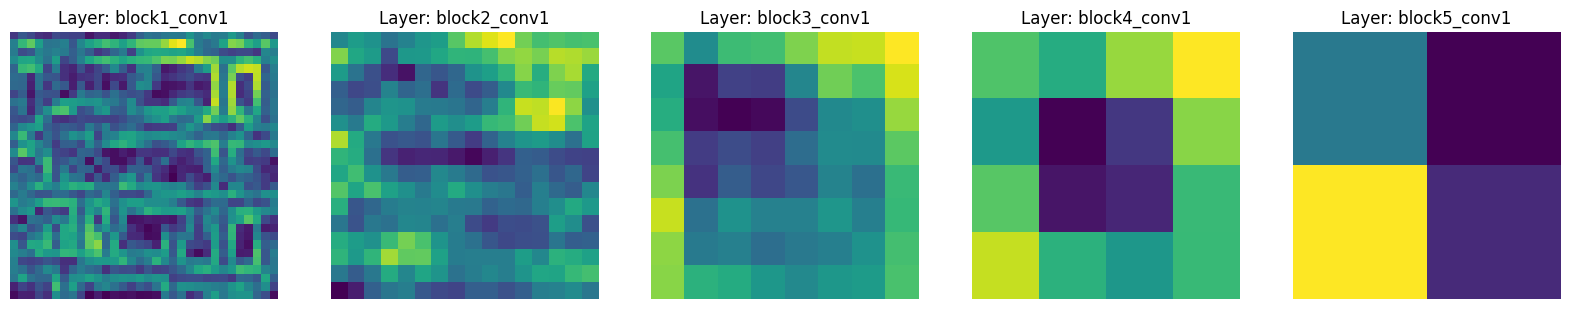

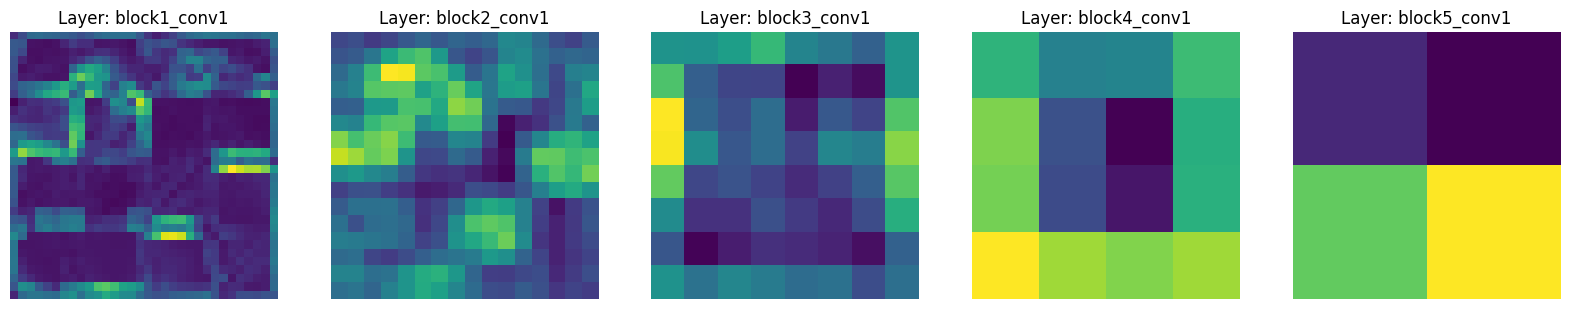

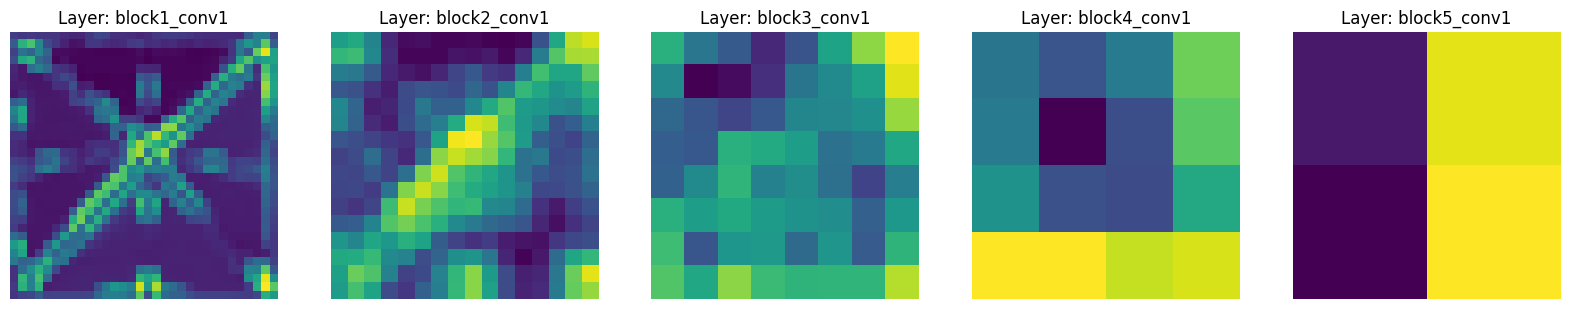

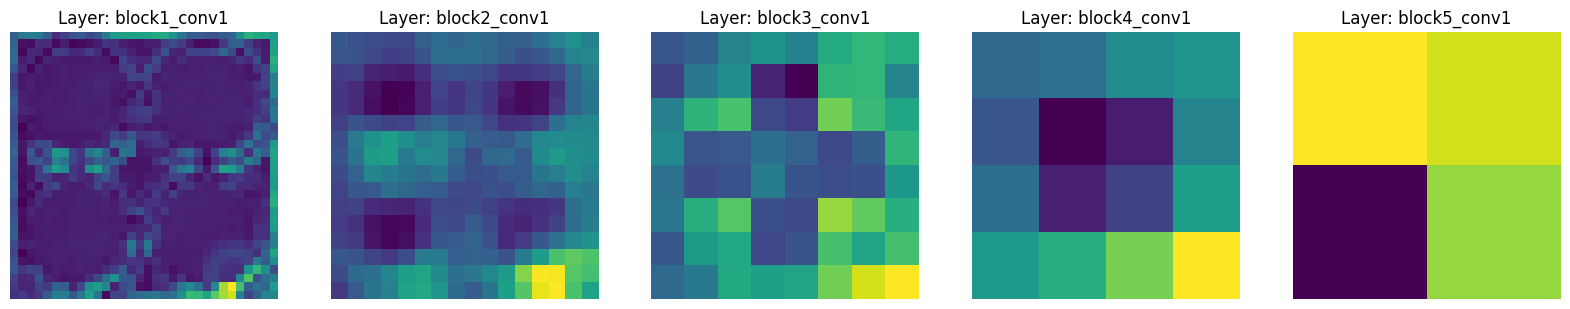

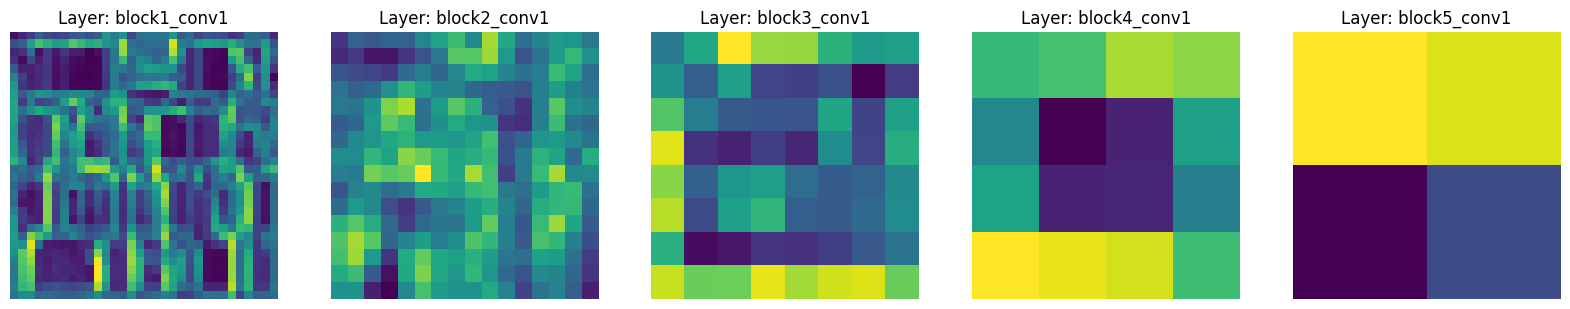

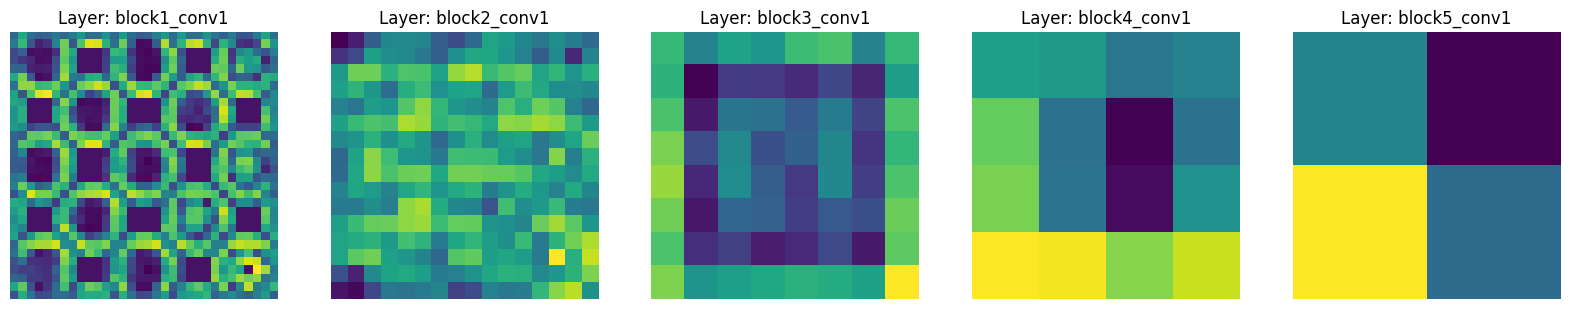

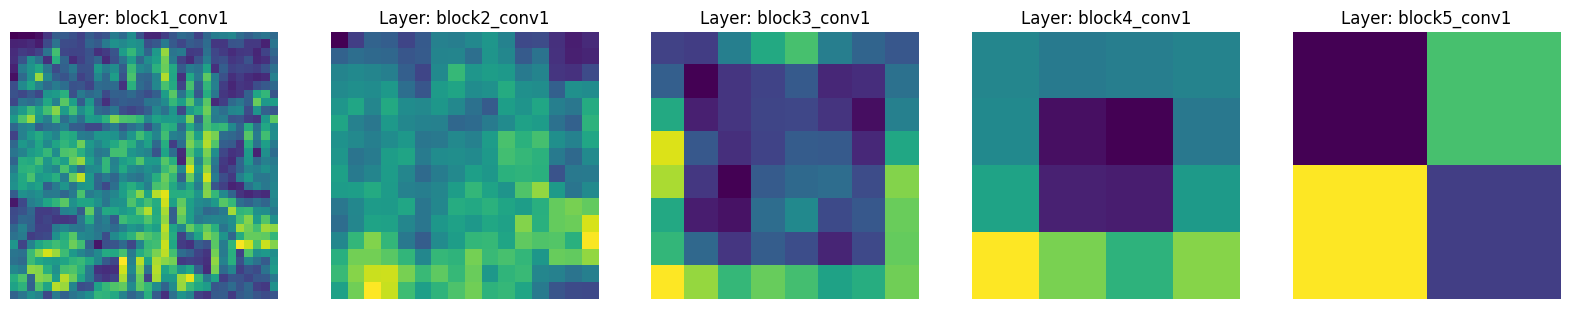

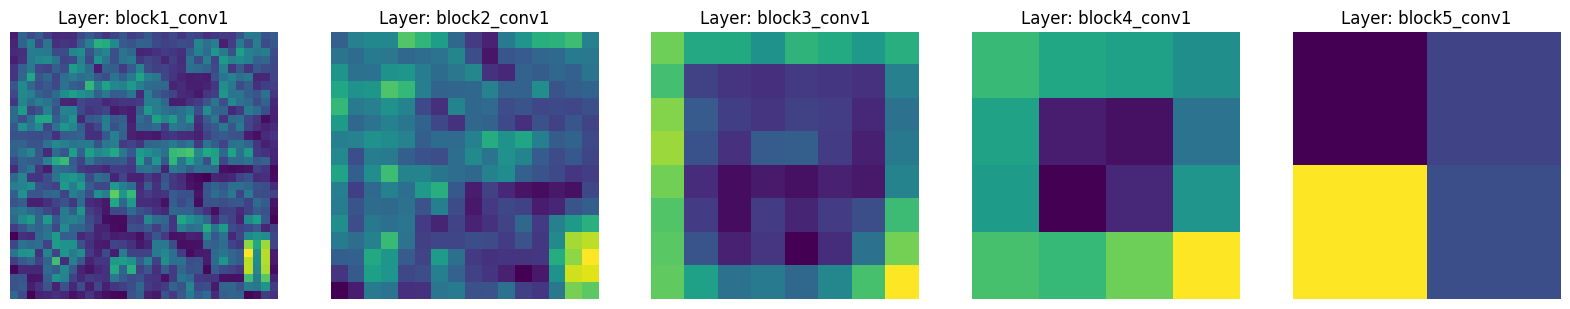

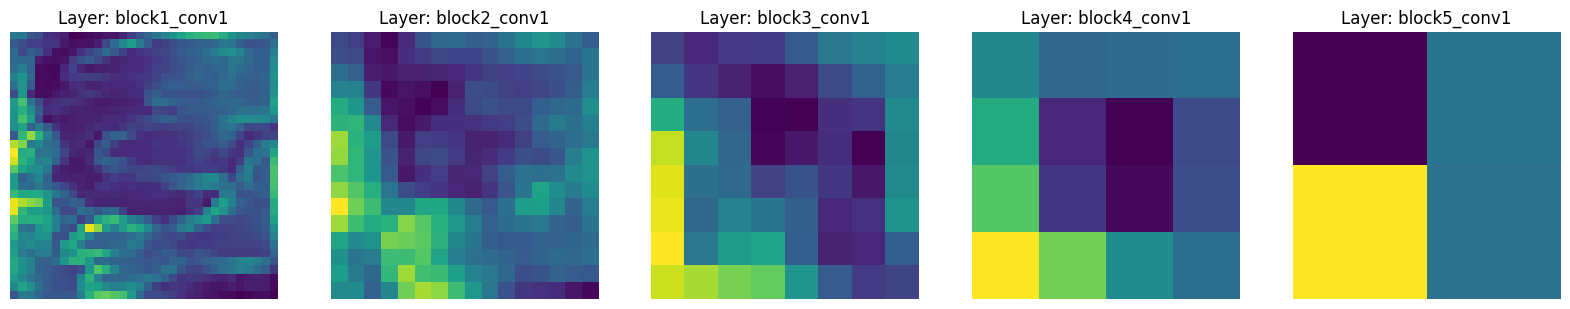

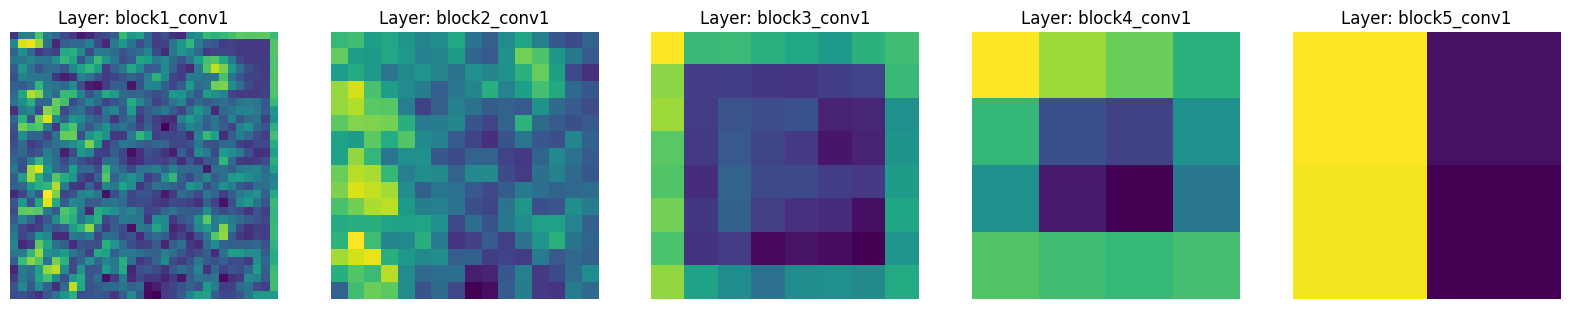

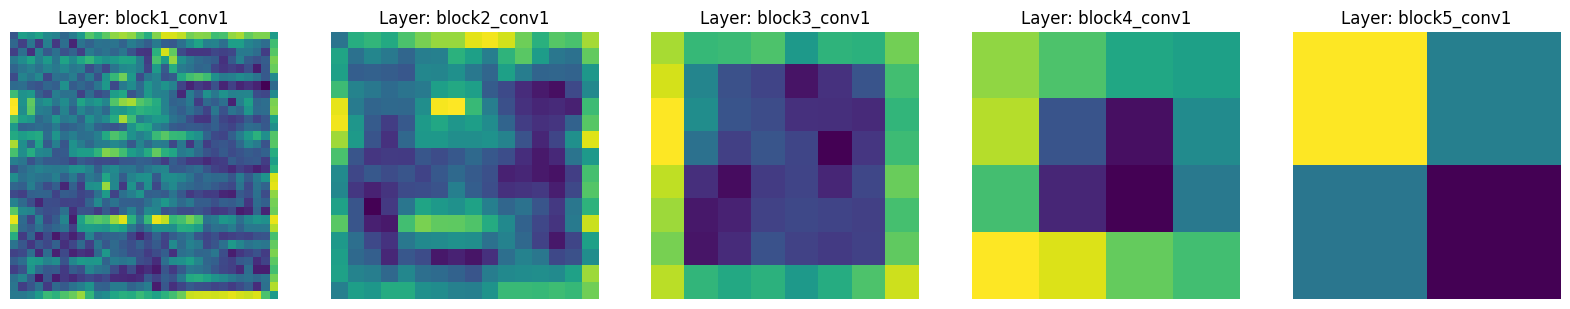

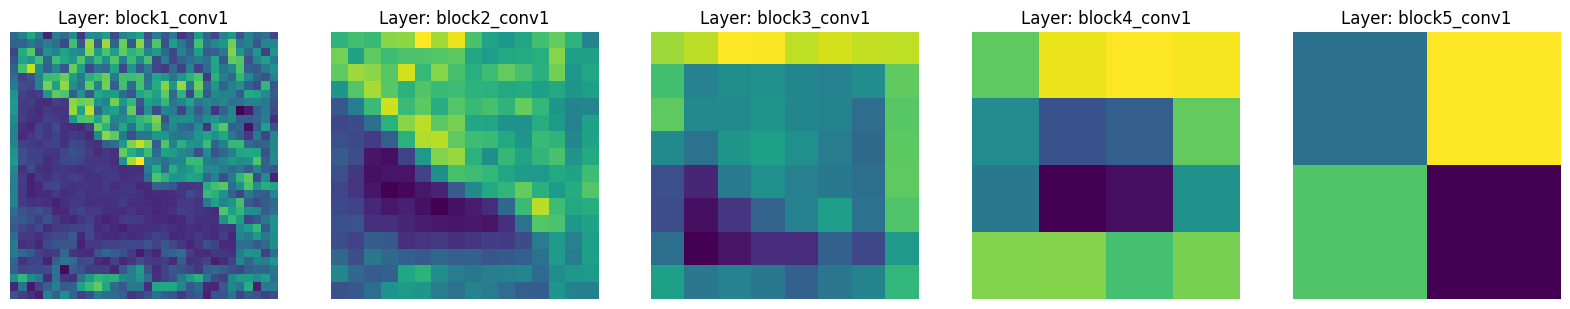

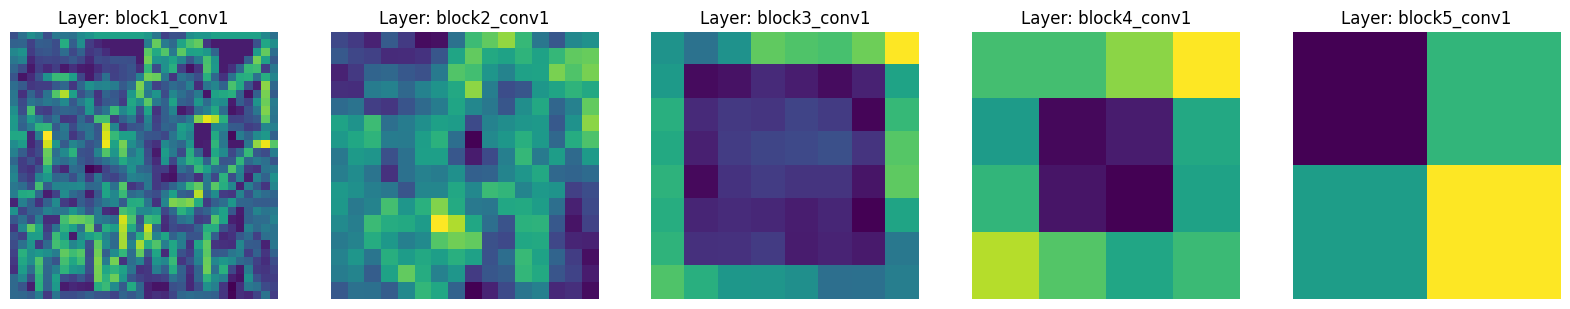

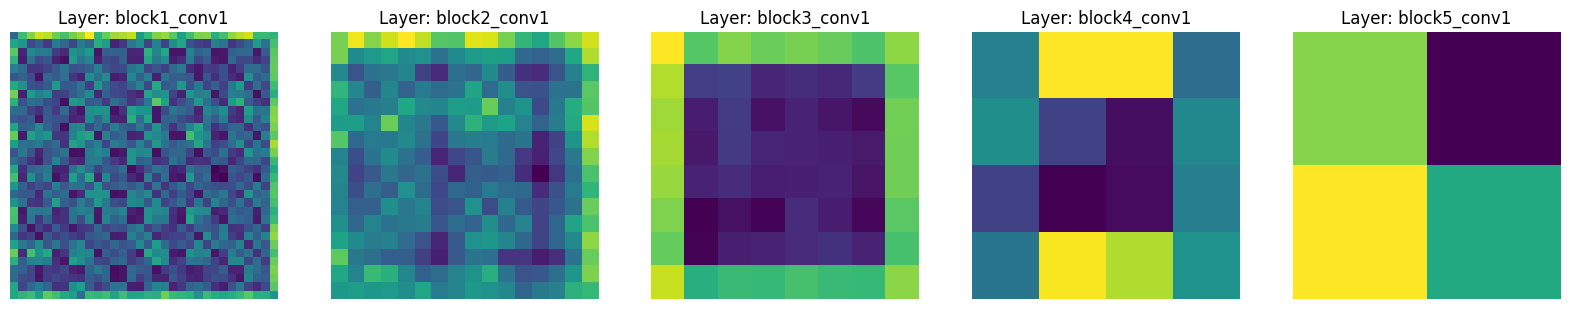

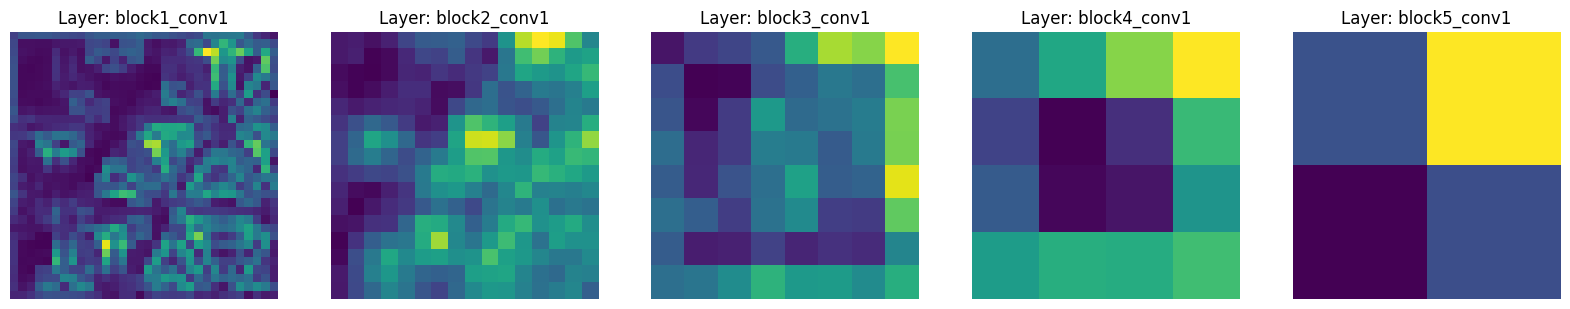

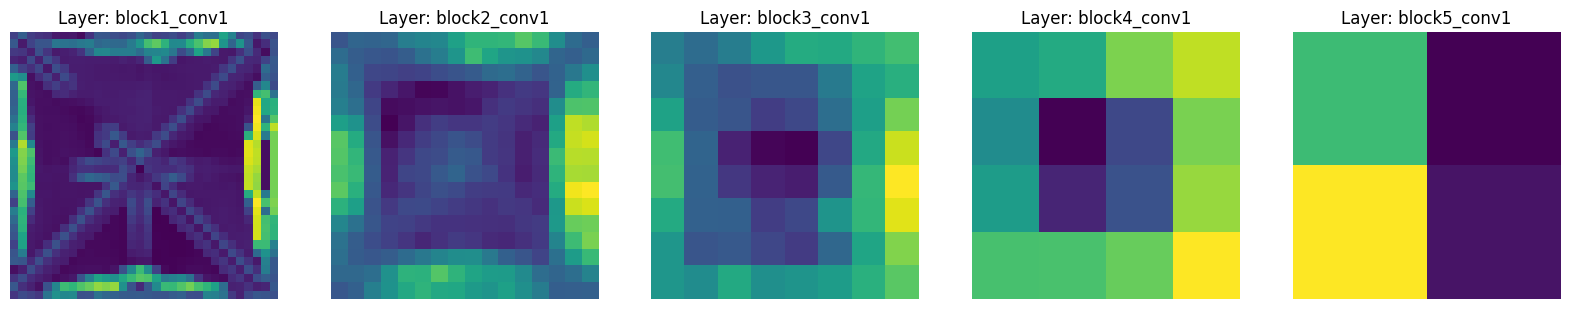

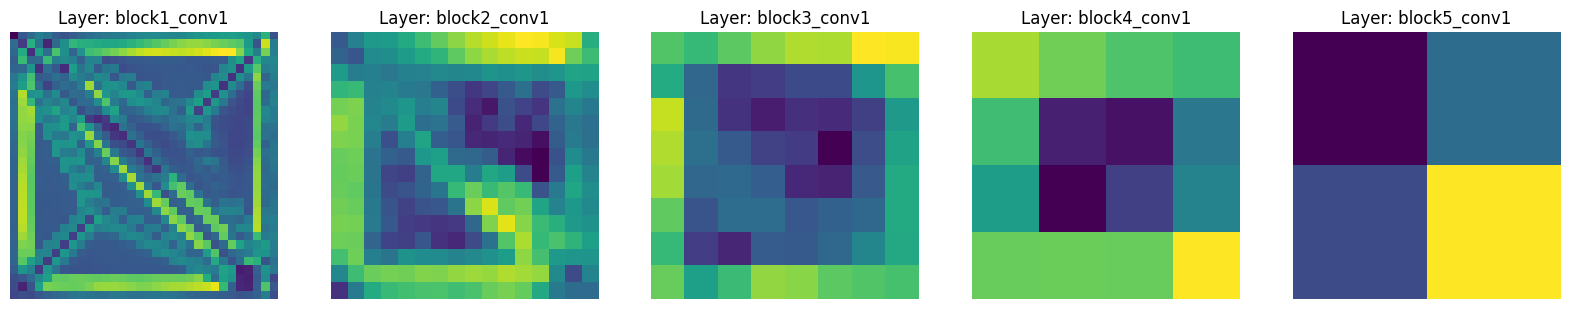

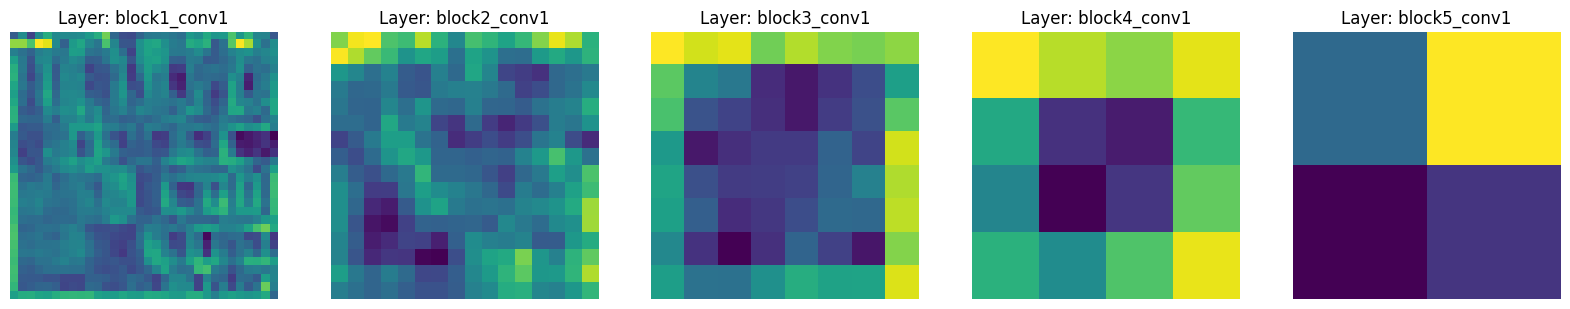

In [5]:
# Select feature type: 'hu', 'hog', or 'vgg19'
feature_type = 'vgg19'  #@param{type:'string'} ['hu', 'hog', 'vgg19']

# Pre-trained VGG19 model for feature extraction (if using vgg19)
if feature_type == 'vgg19':
    vgg_model = VGG19(weights="imagenet", include_top=False)
    layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=outputs)

# Feature extraction function
def extract_features(image_path, feature_type):
    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}")
    new_size = 32  #@param{type:'integer'}
    image = cv2.resize(image, (new_size, new_size))  # Normalize image size to new_size x new_size

    if feature_type == 'hu':
        # Hu Moments
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        moments = cv2.moments(gray)
        features = cv2.HuMoments(moments).flatten()
        return features, None
    elif feature_type == 'hog':
        # HOG features
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features, hog_image = hog(
            gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True
        )
        return features, hog_image
    elif feature_type == 'vgg19':
        # VGG19 feature maps
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array = preprocess_input(image_array)  # Preprocess for VGG19
        feature_maps = vgg_feature_extractor.predict(image_array)  # Extract features from selected layers
        return feature_maps, None  # Return unflattened feature maps
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

# Read all images
image_folder = '/content/drive/My Drive/kenetic_facades/image_a'  #@param{type:'string'}
image_paths = [os.path.join(image_folder, image) for image in os.listdir(image_folder) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]

features = []
hog_images = []
vgg_raw_features = []

for image_path in image_paths:
    try:
        feature, additional_data = extract_features(image_path, feature_type)
        features.append(feature)
        if feature_type == 'hog':
            hog_images.append(additional_data)
        elif feature_type == 'vgg19':
            vgg_raw_features.append(feature)  # Keep raw feature maps for visualization
    except ValueError as e:
        print(e)
        continue

# Visualization based on feature type
if feature_type == 'hu':
    # Print Hu Moments
    print("Hu Moments for all images:")
    for i, feature in enumerate(features):
        print(f"Image {i+1}: {feature}")
elif feature_type == 'hog':
    # Visualize HOG Images
    print("Visualizing HOG Images...")
    n = len(hog_images)
    cols = 5
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(20, 4 * rows))
    for i, hog_image in enumerate(hog_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(hog_image, cmap='gray')
        plt.axis('off')
    plt.show()
elif feature_type == 'vgg19':
    # Visualize VGG19 Feature Maps
    print("Visualizing VGG19 Feature Maps...")
    for i, feature_maps in enumerate(vgg_raw_features):
        try:
            n_layers = len(feature_maps)  # Number of selected layers
            plt.figure(figsize=(20, 4 * n_layers))
            for j, feature_map in enumerate(feature_maps):
                if feature_map.ndim == 4:  # Ensure batch dimension exists
                    feature_map = feature_map[0]  # Remove batch dimension
                # Visualize the raw feature map
                plt.subplot(1, n_layers, j + 1)
                plt.imshow(np.mean(feature_map, axis=-1), cmap='viridis')  # Average over channels for visualization
                plt.title(f"Layer: {layer_names[j]}")
                plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing feature maps for image {i+1}: {e}")
            continue

    # Flatten VGG19 features for KMeans
    features = [np.concatenate([np.mean(f[0], axis=(0, 1)) for f in feature_maps]) for feature_maps in vgg_raw_features]
    features = np.array(features)


All k values are: [7, 6, 6, 5, 5, 5, 6, 5, 5, 7, 6, 5, 7, 6, 6, 7, 6, 6, 6, 6, 6, 7, 7, 6, 7, 7, 6, 4, 7, 6]
The best k value is: 6


<ipython-input-6-cbc687708909>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', 30)
<ipython-input-6-cbc687708909>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range(1, 9), SSE, '-o', marker='x', color=color, label=f'Run {i+1}', linewidth=0.5)


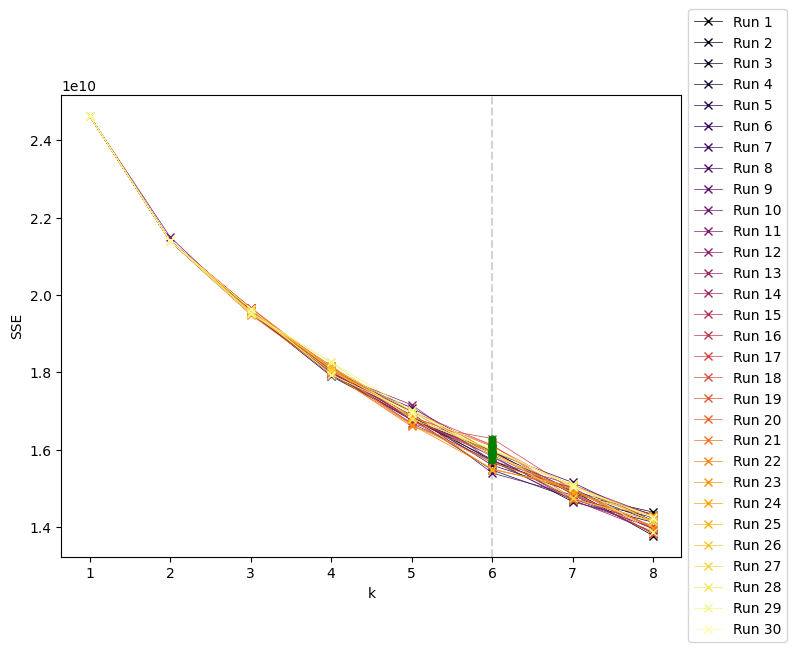

In [6]:
# Use SSE to select k
best_k_values = []  # Store the best k value for each run
SSEs = []  # Store the SSE for each k value

for _ in range(30):  # Run multiple iterations to find stable k
    SSE = []  # Store the sum of squared errors for each result
    for k in range(1, 9):
        estimator = KMeans(n_clusters=k, n_init=10)  # Construct the classifier
        estimator.fit(features)  # Fit the features
        SSE.append(estimator.inertia_)
    # Use second derivative to find the elbow point
    best_k = np.argmin(np.diff(SSE, 2)) + 2
    best_k_values.append(best_k)
    SSEs.append(SSE)

# Print all k values
print(f"All k values are: {best_k_values}")

# Find the most common k value
counter = Counter(best_k_values)
best_k = counter.most_common(1)[0][0]

print(f"The best k value is: {best_k}")

# Create a colour map
cmap = plt.cm.get_cmap('inferno', 30)

# Plot the line graph
fig, ax = plt.subplots(figsize=(10, 6))

# Draw a light grey vertical dashed line at the best k value
ax.axvline(x=best_k, linestyle='--', color='lightgray')

for i, SSE in enumerate(SSEs):
    color = cmap(i)
    ax.plot(range(1, 9), SSE, '-o', marker='x', color=color, label=f'Run {i+1}', linewidth=0.5)

ax.set_xlabel('k')
ax.set_ylabel('SSE')

# Draw a red marker at the best k value in the line graph
for i, best_k_value in enumerate(best_k_values):
    if best_k_value == best_k:
        ax.plot(best_k_value, SSEs[i][best_k_value-1], 'green', marker='o', markersize=5)

# Move the legend to the right and make it the same height as the chart
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [7]:
# K-means clustering
kmeans = KMeans(n_clusters=best_k,  n_init='auto').fit(features)
labels = kmeans.labels_

# Add labels to the original data frame
df = pd.DataFrame()
df['labels'] = kmeans.labels_

# Save the data frame to a CSV file
df.to_csv('/content/drive/My Drive/kmeans_output.csv', index=False)


<ipython-input-8-6cc4c302d12a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', best_k)


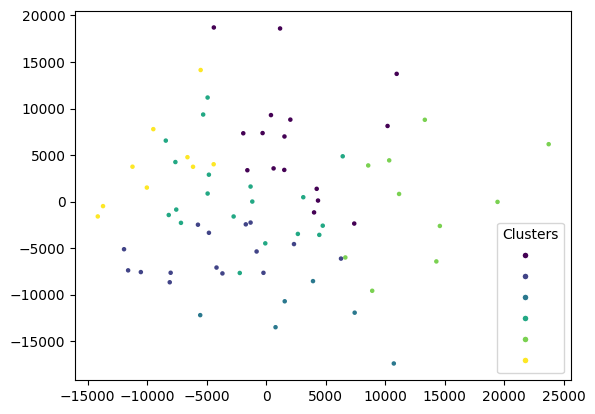

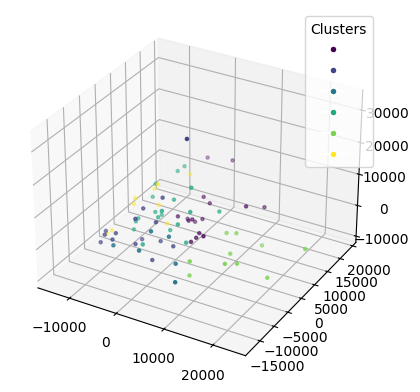

In [8]:
# If the dimensionality of the features is greater than 3, we use PCA for dimensionality reduction
if features.shape[1] > 3:
    pca = PCA(n_components=3)
    features = pca.fit_transform(features)

from matplotlib.lines import Line2D

# Create a colour map
cmap = plt.cm.get_cmap('viridis', best_k)

# 2D visualisation
scatter = plt.scatter(features[:, 0], features[:, 1], s=5, c=labels, cmap=cmap)
# Create handles for the legend
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")
plt.show()

# 3D visualisation
if features.shape[1] > 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Scatter plot for 3D data
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], s=5, c=labels, cmap=cmap)
    # Create handles for the legend
    legend2_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
    ax.legend(handles=legend2_handles, title="Clusters")
    plt.show()


<ipython-input-9-849c55b96f38>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', best_k)


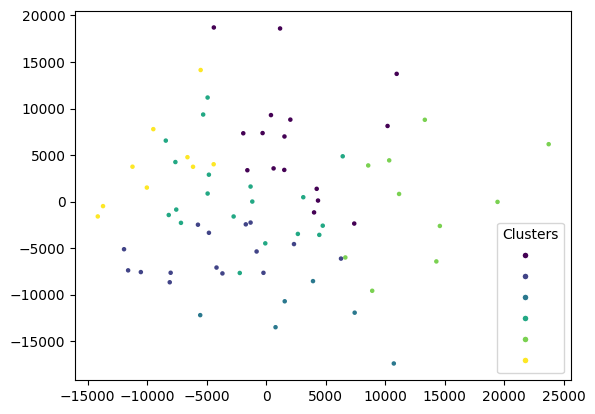

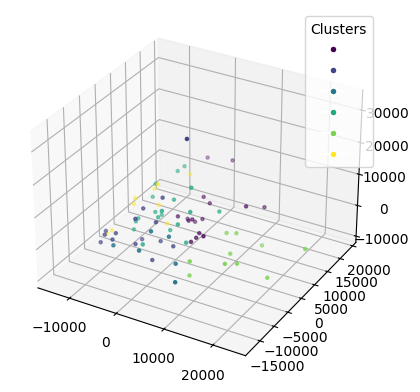

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Ensure `features` is a NumPy array
features = np.array(features)

# If the dimensionality of the features is greater than 3, use PCA for dimensionality reduction
if features.shape[1] > 3:
    pca = PCA(n_components=3)
    features = pca.fit_transform(features)

# Create a colour map
cmap = plt.cm.get_cmap('viridis', best_k)

# 2D visualisation
scatter = plt.scatter(features[:, 0], features[:, 1], s=5, c=labels, cmap=cmap)
# Create handles for the legend
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")
plt.show()

# 3D visualisation
if features.shape[1] > 2:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Scatter plot for 3D data
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], s=5, c=labels, cmap=cmap)
    # Create handles for the legend
    legend2_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
    ax.legend(handles=legend2_handles, title="Clusters")
    plt.show()


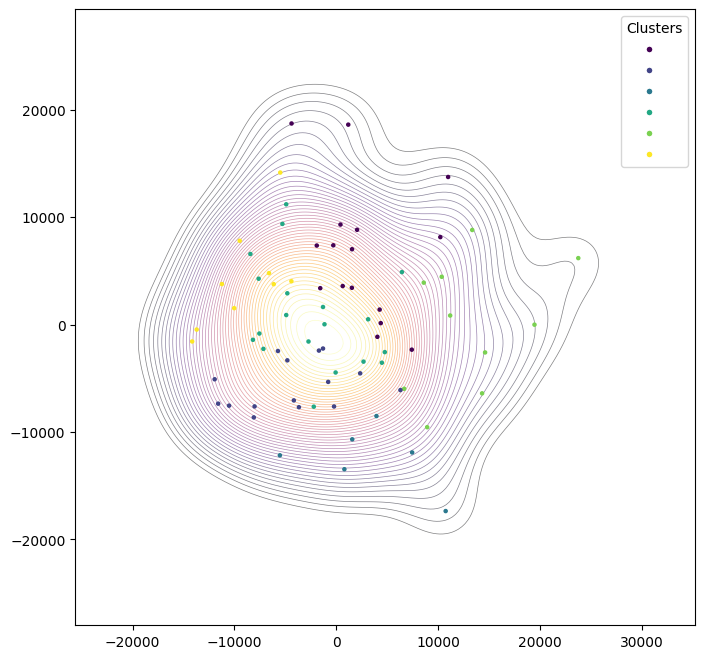

In [10]:
# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Create a new figure
plt.figure(figsize=(8, 8))

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# First, plot the Kernel Density Estimation
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)

# Then, plot the scatter plot
scatter = plt.scatter(x, y, s=5, c=labels, cmap=cmap)
# Create legend handles for the clusters
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")

plt.show()


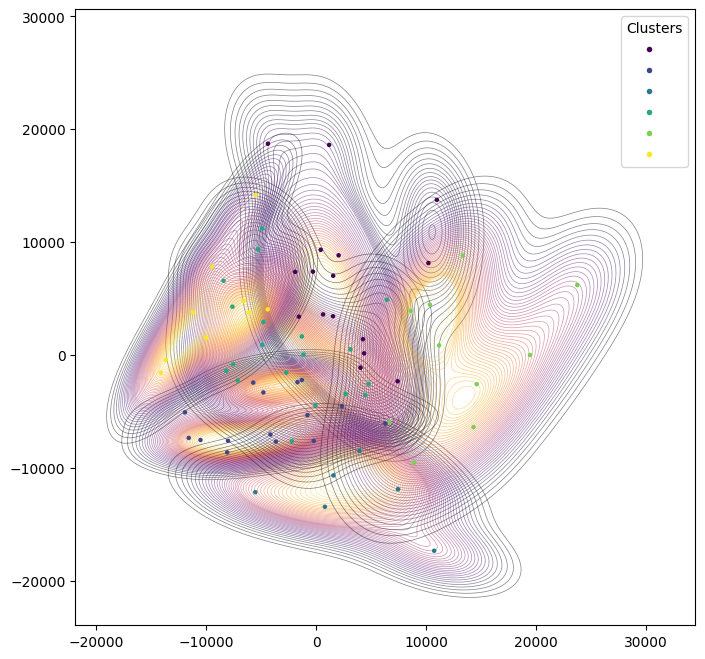

In [11]:
# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Create a new figure
plt.figure(figsize=(8, 8))

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# Plot Kernel Density Estimation for each cluster separately
for i in range(best_k):
    cluster_data = data[labels == i]
    sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1)

# Then, plot the scatter plot
scatter = plt.scatter(x, y, s=5, c=labels, cmap=cmap)
# Create legend handles for the clusters
legend1_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/best_k), markersize=5) for i in range(best_k)]
plt.legend(handles=legend1_handles, title="Clusters")

plt.show()


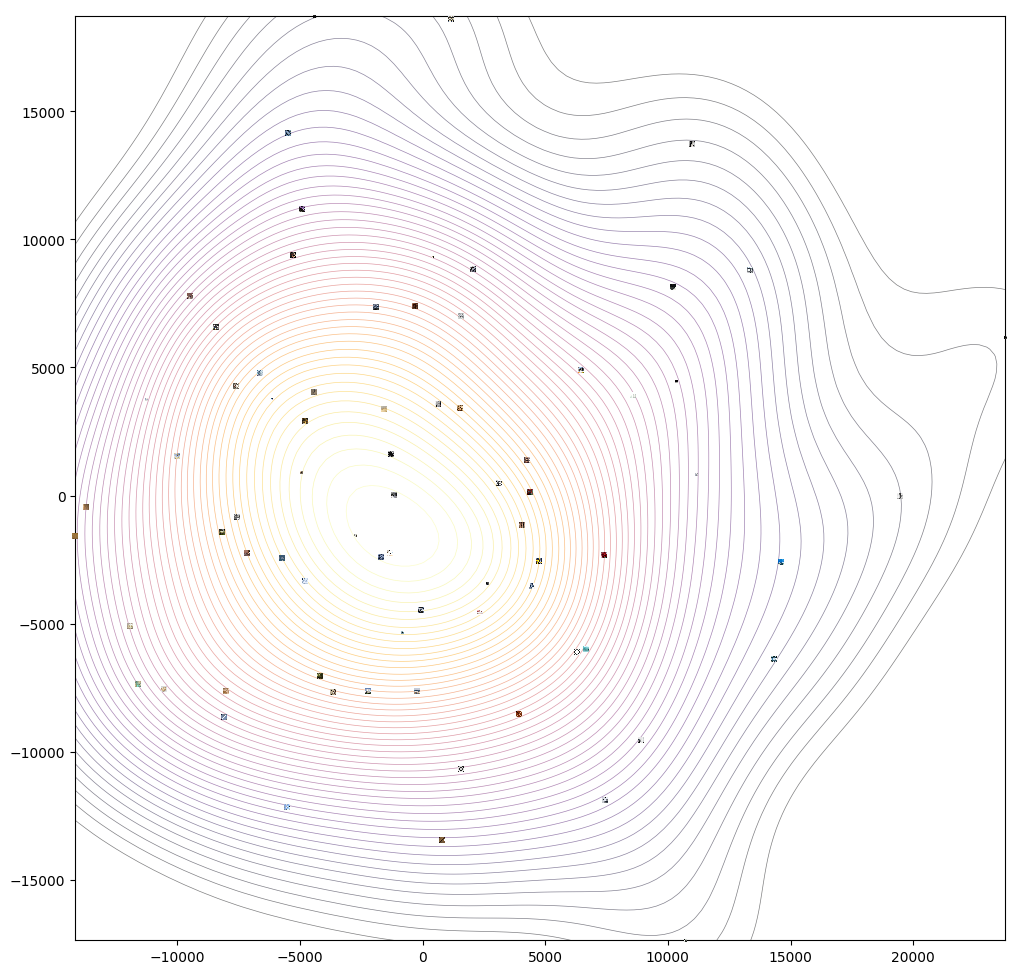

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Helper function to load and resize images for plotting
def get_image(path, zoom=0.1):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return OffsetImage(image, zoom=zoom)

# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the KDE on the same axes
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1, ax=ax)

# Overlay scatter plot with images
for i, (x0, y0) in enumerate(zip(x, y)):
    img = get_image(image_paths[i], zoom=0.001)  # Adjust zoom as needed
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)

# Adjust the limits of the plot to make sure everything fits
margin = 0.2
ax.set_xlim(data[:, 0].min() - margin, data[:, 0].max() + margin)
ax.set_ylim(data[:, 1].min() - margin, data[:, 1].max() + margin)

plt.show()


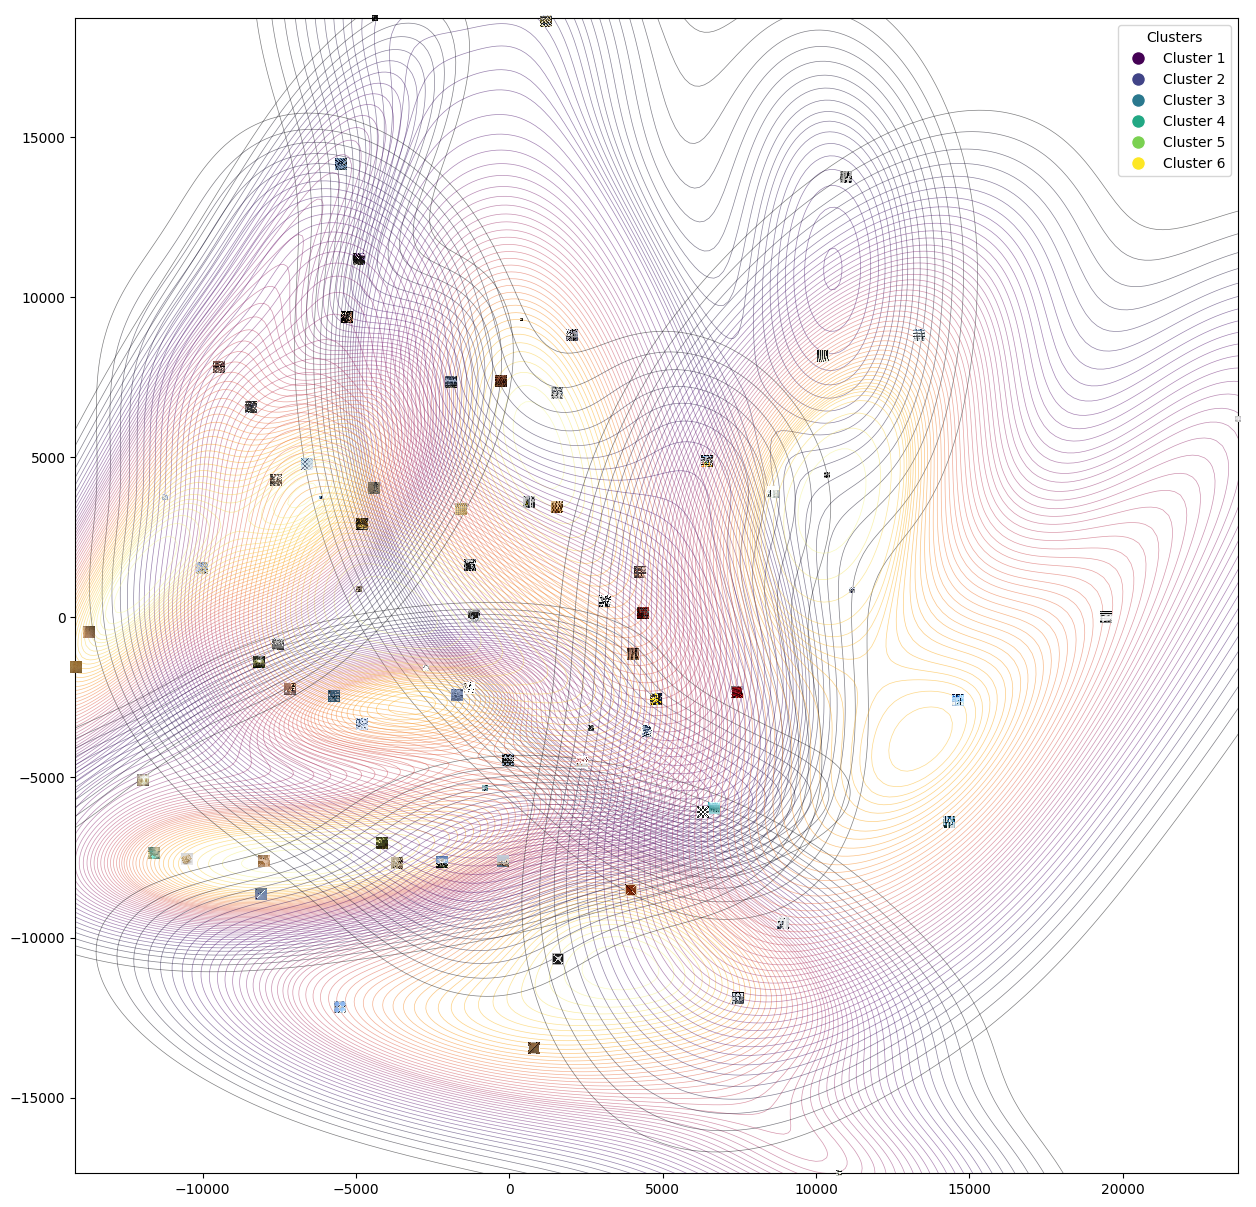

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Helper function to load and resize images for plotting
def get_image(path, zoom=0.2):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return OffsetImage(image, zoom=zoom)

# Assuming you have two dimensions in your features
x = features[:, 0]
y = features[:, 1]

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# Create the figure and axes with size 15x15
fig, ax = plt.subplots(figsize=(15, 15))

# Plot Kernel Density Estimation for each cluster separately
for i in range(best_k):
    cluster_data = data[labels == i]
    sns.kdeplot(x=cluster_data[:, 0], y=cluster_data[:, 1], cmap="inferno", fill=False, levels=50, thresh=0.05, linewidths=0.5, alpha=0.5, zorder=1, ax=ax)

# Overlay scatter plot with images
for i, (x0, y0) in enumerate(zip(x, y)):
    img = get_image(image_paths[i], zoom=0.002)  # Adjust zoom as needed
    ab = AnnotationBbox(img, (x0, y0), frameon=False)
    ax.add_artist(ab)

# Adjust the limits of the plot to make sure everything fits
margin = 0.2
ax.set_xlim(data[:, 0].min() - margin, data[:, 0].max() + margin)
ax.set_ylim(data[:, 1].min() - margin, data[:, 1].max() + margin)

# Add cluster legend with numbers
legend1_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / best_k), markersize=10, label=f'Cluster {i+1}')
    for i in range(best_k)
]
ax.legend(handles=legend1_handles, title="Clusters")

# Save the plot as a high-resolution image
plt.savefig('cluster_visualisation.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
features = np.random.rand(100, 2)  # 示例 2D 特征
labels = np.random.randint(0, 5, size=100)  # 示例聚类标签




In [15]:
import plotly.graph_objects as go
import cv2
import numpy as np
import seaborn as sns

# Helper function to load and resize images for plotting
def get_image_as_datauri(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, buffer = cv2.imencode('.png', image)
    data_uri = 'data:image/png;base64,' + buffer.tobytes().hex()
    return data_uri

# Check lengths of image_paths and features
print(f"Number of image paths: {len(image_paths)}")
print(f"Number of feature rows: {features.shape[0]}")

# Ensure lengths match
min_length = min(len(image_paths), features.shape[0])
image_paths = image_paths[:min_length]
features = features[:min_length]
labels = labels[:min_length]  # Ensure labels are also aligned

# Extract x and y from features
x = features[:, 0]
y = features[:, 1]

# Combine x and y into a two-dimensional array
data = np.vstack([x, y]).T

# Create scatter plot with images
fig = go.Figure()

# Add KDE traces for each cluster
for i in range(best_k):
    cluster_data = data[labels == i]
    if len(cluster_data) > 1:  # Ensure there are enough points for KDE
        sns.set(style="whitegrid")
        kde = sns.kdeplot(
            x=cluster_data[:, 0],
            y=cluster_data[:, 1],
            cmap="inferno",
            fill=False,
            levels=50,
            thresh=0.05,
            linewidths=0.5
        )
        kde_points = kde.collections[0].get_paths()[0].vertices
        fig.add_trace(
            go.Scatter(
                x=kde_points[:, 0],
                y=kde_points[:, 1],
                mode='lines',
                line=dict(color='orange', width=1),
                showlegend=False
            )
        )

# Add images as markers, with bounds checking
for i, (x0, y0) in enumerate(zip(x, y)):
    img_data_uri = get_image_as_datauri(image_paths[i])
    fig.add_trace(
        go.Scatter(
            x=[x0],
            y=[y0],
            mode='markers',
            marker=dict(
                size=20,
                symbol='circle',
                opacity=0.7
            ),
            hovertemplate=f'<img src="{img_data_uri}" width="50" height="50">'
        )
    )

# Set layout for interactive zooming
fig.update_layout(
    title="Interactive Cluster Visualisation",
    xaxis=dict(title="Dimension 1"),
    yaxis=dict(title="Dimension 2"),
    dragmode="pan",  # Enable dragging
    hovermode="closest",  # Enable hover functionality
    template="plotly_white"
)

# Render Plotly Figure in Colab
fig.show(renderer="colab")  # Specify Colab renderer


Number of image paths: 75
Number of feature rows: 100
